<a href="https://colab.research.google.com/github/AndreiAf02/Job-Satisfaction/blob/main/Job_Satisfaction_AT_MCMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from scipy.stats import bootstrap, norm
import pymc as pm
import arviz as az

## Data Preprocessing:

In [2]:
# path_to_data = 'https://raw.githubusercontent.com/EduardoAve/Labour-well-being/refs/heads/main/data/02_processed/'
path_to_data2 = 'https://raw.githubusercontent.com/EduardoAve/Labour-well-being/refs/heads/main/data/01_raw-00/'

In [3]:
data_total = pd.read_csv(path_to_data2+ "Final_Dataset.csv", sep=",", header=0)
data_total.columns = data_total.columns.str.replace(".","")

data_total

,Country,Version,1 Gender:,2 Age (in years):,Unnamed: 4,3 Nationality:,4 Current marital (partnership) status:,5 Do you currently care for underage children or dependent relatives?,6 The type of higher education insitution where you primarily work:,7 Subject area of the faculty (higher education institution) where you primarily work:,...,36 I tend to overwork,37 I don’t consider my work to be finished until I am completely satisfied with the result,38 My thoughts revolve around work almost exclusively,"39 When I’m unsuccessful at work, it makes me feel very down","40 If I don’t succeed at something, that just makes me all the more determined",41 I can be calm and collected in almost all situations,42 My life up till now has been characterized by professional success,"43 By and large, I am happy and content",44 I have the full support of my family,Vulnerability
0,2,4,2.0,28.0,2.0,Spanish,3.0,1.0,1.0,1.0,...,4.0,4.0,3.0,4.0,1.0,4.0,1.0,3.0,5.0,4.0
1,2,4,1.0,33.0,2.0,German,2.0,1.0,1.0,3.0,...,5.0,5.0,4.0,4.0,3.0,3.0,2.0,2.0,5.0,4.0
2,2,4,2.0,32.0,2.0,Kosovan,3.0,1.0,NaN,5.0,...,4.0,4.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,3.0
3,2,4,NaN,30.0,2.0,Spain,2.0,1.0,1.0,5.0,...,4.0,5.0,1.0,5.0,2.0,4.0,2.0,3.0,3.0,4.0
4,2,4,1.0,39.0,2.0,Italian,2.0,2.0,1.0,5.0,...,5.0,5.0,3.0,3.0,3.0,2.0,4.0,4.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2742,1,1,1.0,27.0,4.0,NaN,2.0,1.0,4.0,1.0,...,2.0,4.0,2.0,3.0,2.0,3.0,4.0,3.0,4.0,2.0
2743,1,1,1.0,80.0,3.0,NaN,1.0,1.0,4.0,6.0,...,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN
2744,1,1,2.0,27.0,6.0,NaN,3.0,1.0,4.0,3.0,...,2.0,3.0,1.0,1.0,3.0,3.0,5.0,5.0,3.0,2.0
2745,1,1,2.0,28.0,4.0,NaN,3.0,1.0,4.0,1.0,...,5.0,4.0,4.0,4.0,3.0,3.0,3.0,1.0,4.0,NaN


In [4]:
print(data_total.columns.tolist())

['Country', 'Version', '1 Gender:', '2 Age (in years):', 'Unnamed: 4', '3 Nationality:', '4 Current marital (partnership) status:', '5 Do you currently care for underage children or dependent relatives?', '6 The type of higher education insitution where you primarily work:', '7 Subject area of the faculty (higher education institution) where you primarily work:', '8 Duration of your current employment contract at the higher education institution where you primarily work:', '9 Extent of employment in higher education (in hours/week, aggregated for all higher education institutions where you work):', '10 Actual average weekly working hours in higher education (in a typical semester week):', 'Effort (less, more, equal)', 'Effort [%]', 'Income CZK', 'Income EURO', 'Euro Adj', 'Salary/hour', 'Salary effort/hour', '12 Do you hold a leadership position at a higher education institution?', '13 How influential are you in helping to shape key academic policies at your institution at the level of

In [5]:
print(data_total['Salary/hour'][data_total['Income EURO']>=10**5])

1858    692.3076923076923
2037    576.9230769230769
2490    692.3076923076923
2499                  750
2538                  750
2559    692.3076923076923
2562    634.6153846153845
2583    576.9230769230769
Name: Salary/hour, dtype: object


In [6]:
data_at_total = data_total[data_total['Country']==1].reset_index(drop=True)
# data_cz_total = data_total[data_total['Country']==2].reset_index(drop=True)
data_at_total

,Country,Version,1 Gender:,2 Age (in years):,Unnamed: 4,3 Nationality:,4 Current marital (partnership) status:,5 Do you currently care for underage children or dependent relatives?,6 The type of higher education insitution where you primarily work:,7 Subject area of the faculty (higher education institution) where you primarily work:,...,36 I tend to overwork,37 I don’t consider my work to be finished until I am completely satisfied with the result,38 My thoughts revolve around work almost exclusively,"39 When I’m unsuccessful at work, it makes me feel very down","40 If I don’t succeed at something, that just makes me all the more determined",41 I can be calm and collected in almost all situations,42 My life up till now has been characterized by professional success,"43 By and large, I am happy and content",44 I have the full support of my family,Vulnerability
0,1,3,1.0,47.0,7.0,Hungary,1.0,2.0,5.0,5.0,...,4.0,2.0,3.0,3.0,3.0,4.0,5.0,5.0,5.0,3.0
1,1,3,2.0,35.0,NaN,NaN,1.0,2.0,6.0,2.0,...,4.0,4.0,4.0,4.0,4.0,2.0,3.0,3.0,4.0,4.0
2,1,3,1.0,51.0,7.0,Australian,3.0,1.0,4.0,5.0,...,4.0,2.0,4.0,5.0,2.0,5.0,3.0,4.0,4.0,4.0
3,1,3,1.0,34.0,7.0,Belgian,2.0,1.0,4.0,7.0,...,2.0,4.0,1.0,4.0,3.0,3.0,4.0,4.0,4.0,4.0
4,1,3,2.0,29.0,7.0,Ecuadorian,2.0,1.0,4.0,2.0,...,4.0,4.0,1.0,4.0,4.0,3.0,4.0,4.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,1,1,1.0,27.0,4.0,NaN,2.0,1.0,4.0,1.0,...,2.0,4.0,2.0,3.0,2.0,3.0,4.0,3.0,4.0,2.0
1324,1,1,1.0,80.0,3.0,NaN,1.0,1.0,4.0,6.0,...,3.0,3.0,4.0,3.0,3.0,3.0,3.0,3.0,NaN,NaN
1325,1,1,2.0,27.0,6.0,NaN,3.0,1.0,4.0,3.0,...,2.0,3.0,1.0,1.0,3.0,3.0,5.0,5.0,3.0,2.0
1326,1,1,2.0,28.0,4.0,NaN,3.0,1.0,4.0,1.0,...,5.0,4.0,4.0,4.0,3.0,3.0,3.0,1.0,4.0,NaN


In [7]:
data_at_job = data_at_total[['2 Age (in years):',
    'AT_15 Your current position at the higher education institution, where you primarily work: ', ## Current Position
    'Salary/hour',
    # '8 Duration of your current employment contract at the higher education institution where you primarily work:', ## Contract Duration
    '10 Actual average weekly working hours in higher education (in a typical semester week):', ## Actual Weekly Working Hours
    'Effort [%]', ## Effort = actual hours/contract hours
    '1 Teaching (classroom instruction, preparation of instructional materials and lesson plans, advising students, reading and evaluating student work, examination management, etc)', ## Teaching hours
    '2 Research (reading literature, designing and conducting experiments, collecting and analysing data, writing articles or other scientific texts, etc)', ## Research Hours
    '3 Activities related to externally funded research projects (searching for information on available funding sources, preparation of grant applications and project reports, project management and administration, etc)', ## Research Admin hours
    '4 Organisational and administrative activities (organising and attending meetings, dealing with tasks and documents not directly related to teaching, research, or externally funded research projects, etc)', ## General Admin hours
    # '12 Do you hold a leadership position at a higher education institution?', ## Leadership position
    '13 How influential are you in helping to shape key academic policies at your institution at the level of department or similar unit?', ## Policy Influence
    ## ACADEMIC RESOURCES:
    '1 Facilities and technological equipment (offices, classrooms, laboratories, computers, projectors, teaching software)', ## Academic Resources - FACILITIES
    '2 Research equipment (instruments, tools, materials, software for working with data)', ## Academic Resources - RESEARCH EQUIP
    '3 Availability of scientific literature (access to up-to-date scientific articles and books)', ## Academic Resources - LITERATURE
    '4 Personnel support (support from secretarial, administrative and technical staff, laboratory technicians, etc)', ## Academic Resources - SUPPORT
    '5 Opportunities for personal and professional development (offer and availability of professional courses and internships, opportunities to participate at conferences and other professional events)', ## Academic Resources - PD
    '6 Availability of resources for research funding', ## Academic Resources - FUNDING
    ## PERFORMANCE PRESSURE:
    # '1 At my institution, there is a strong performance orientation',
    ## PERCEIVED AUTONOMY:
    '2 I feel like I can be myself at my job', ## KEEP ORDER
    "3 At work, I often feel like I have to follow other people’s commands", ## TO INVERT
    '4 If I could choose, I would do things at work differently', ## TO INVERT
    '5 The tasks I have to do at work are in line with what I really want to do', ## KEEP ORDER
    '6 I feel free to do my job the way I think it could best be done', ## KEEP ORDER
    '7 In my job, I feel forced to do things I do not want to do ', ## TO INVERT
    ## QUALITY OF LEADERSHIP:
    # '1  makes sure that the members of staff have good development opportunities', ## KEEP ORDER
    # '2  gives high priority to job satisfaction', ## KEEP ORDER
    # '3  is good at work planning', ## KEEP ORDER
    # '4  is good at solving conflicts ', ## KEEP ORDER
    ## SENSE OF COMMUNITY:
    # '1 There is a good atmosphere between myself and my colleagues ',
    # '2 There is good co-operation between the colleagues at work',
    # '3 I feel part of a community at my place of work',
    ## JOB SATISFACTION:
    '1  your work prospects? ',
    '2   the physical working conditions (eg facilities, equipment, physical working environment)?',
    '3  the way your abilities are used?',
    '4  your salary?',
    '5  your job as a whole, everything taken into consideration? '
]]

In [8]:
data_at_job.columns.tolist()

['2 Age (in years):',
 'AT_15 Your current position at the higher education institution, where you primarily work: ',
 'Salary/hour',
 '10 Actual average weekly working hours in higher education (in a typical semester week):',
 'Effort [%]',
 '1 Teaching (classroom instruction, preparation of instructional materials and lesson plans, advising students, reading and evaluating student work, examination management, etc)',
 '2 Research (reading literature, designing and conducting experiments, collecting and analysing data, writing articles or other scientific texts, etc)',
 '3 Activities related to externally funded research projects (searching for information on available funding sources, preparation of grant applications and project reports, project management and administration, etc)',
 '4 Organisational and administrative activities (organising and attending meetings, dealing with tasks and documents not directly related to teaching, research, or externally funded research projects, e

In [9]:
data_at_job.columns = ['Age',
    'Current_position', ## Current Position
    'Salary',
    # 'Contract_duration', ## Contract Duration
    'Actual_hrs', ## Actual Weekly Working Hours
    'Effort', ## Effort = actual hours/contract hours
    'Teaching_hrs', ## Teaching hours
    'Research_hrs', ## Research Hours
    'External_funding_hrs', ## External Research Funding hours
    'Admin_hrs', ## General Admin hours
    # 'Leadership_position', ## Leadership position
    'Policy_influence', ## Policy Influence
    ## ACADEMIC RESOURCES:
    'Acad_res_facility', ## Academic Resources - FACILITIES
    'Acad_res_equip', ## Academic Resources - RESEARCH EQUIP
    'Acad_res_lit', ## Academic Resources - LITERATURE
    'Acad_res_support', ## Academic Resources - SUPPORT
    'Acad_res_PD', ## Academic Resources - PD
    'Acad_res_funding', ## Academic Resources - FUNDING
    ## PERFORMANCE PRESSURE:
    # 'Performance_pressure',
    ## PERCEIVED AUTONOMY:
    'Be_myself', ## KEEP ORDER
    "Follow_commands", ## TO INVERT
    'Do_differently', ## TO INVERT
    'Want_to_do', ## KEEP ORDER
    'Done_best', ## KEEP ORDER
    'Forced_to_do', ## TO INVERT
    ## QUALITY OF LEADERSHIP:
    # 'Development_opportunities', ## KEEP ORDER
    # 'Prioritizes_satisfaction', ## KEEP ORDER
    # 'Work_planning', ## KEEP ORDER
    # 'Solving_conflicts', ## KEEP ORDER
    ## SENSE OF COMMUNITY:
    # 'Good_atmosphere',
    # 'Good_cooperation',
    # 'Part_of_community',
    ## JOB SATISFACTION:
    'Work_prospects',
    'Physical_working_conditions',
    'Use_of_abilities',
    'Satisfaction_w_salary',
    'Overall_satisfaction']

In [10]:
data_at_job.columns.tolist()

['Age',
 'Current_position',
 'Salary',
 'Actual_hrs',
 'Effort',
 'Teaching_hrs',
 'Research_hrs',
 'External_funding_hrs',
 'Admin_hrs',
 'Policy_influence',
 'Acad_res_facility',
 'Acad_res_equip',
 'Acad_res_lit',
 'Acad_res_support',
 'Acad_res_PD',
 'Acad_res_funding',
 'Be_myself',
 'Follow_commands',
 'Do_differently',
 'Want_to_do',
 'Done_best',
 'Forced_to_do',
 'Work_prospects',
 'Physical_working_conditions',
 'Use_of_abilities',
 'Satisfaction_w_salary',
 'Overall_satisfaction']

In [11]:
data_at_job = data_at_job.dropna(subset=['Age']).reset_index(drop=True)
data_at_job = data_at_job[~(data_at_job == '#VALUE!').any(axis=1)]
for col in data_at_job.columns:
  data_at_job[col] = data_at_job[col].astype(str).str.replace(',', '.').astype(float)
data_at_job.to_csv('data_at_job.csv')
data_at_job

,Age,Current_position,Salary,Actual_hrs,Effort,Teaching_hrs,Research_hrs,External_funding_hrs,Admin_hrs,Policy_influence,...,Follow_commands,Do_differently,Want_to_do,Done_best,Forced_to_do,Work_prospects,Physical_working_conditions,Use_of_abilities,Satisfaction_w_salary,Overall_satisfaction
0,47.0,2.0,86.538462,40.0,100.000000,12.0,6.0,6.0,16.0,4.0,...,2.0,2.0,4.0,5.0,2.0,4.0,5.0,5.0,5.0,5.0
1,35.0,8.0,22.788462,45.0,112.500000,NaN,35.0,10.0,NaN,1.0,...,4.0,3.0,3.0,4.0,2.0,3.0,4.0,4.0,3.0,3.0
2,51.0,13.0,20.192308,40.0,100.000000,0.0,10.0,10.0,80.0,2.0,...,4.0,5.0,1.0,3.0,5.0,4.0,3.0,1.0,1.0,2.0
3,34.0,8.0,17.884615,50.0,125.000000,15.0,30.0,2.0,5.0,3.0,...,3.0,2.0,4.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0
4,29.0,11.0,26.373626,35.0,100.000000,1.0,20.0,9.0,5.0,1.0,...,3.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,27.0,9.0,18.907500,35.0,116.666667,0.0,25.0,1.0,4.0,2.0,...,4.0,5.0,2.0,2.0,4.0,4.0,4.0,2.0,1.0,2.0
1311,80.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,2.0,4.0,4.0,2.0,4.0,4.0,4.0,3.0,3.0
1312,27.0,9.0,22.061538,30.0,100.000000,0.0,25.0,0.0,5.0,1.0,...,4.0,2.0,4.0,5.0,1.0,2.0,2.0,4.0,3.0,4.0
1313,28.0,9.0,13.461538,42.0,116.666667,2.0,40.0,0.0,0.0,1.0,...,5.0,4.0,2.0,1.0,4.0,1.0,2.0,2.0,1.0,2.0


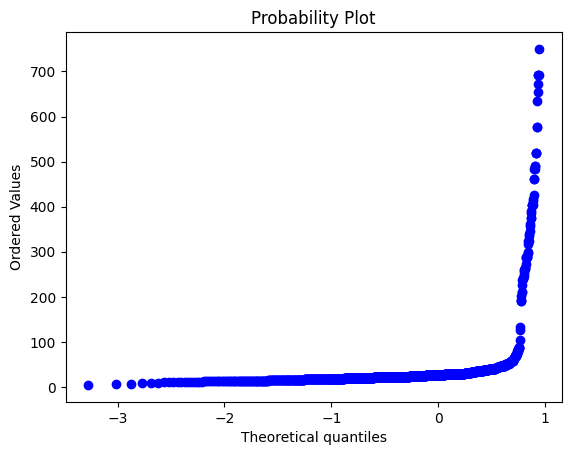

In [12]:
stats.probplot(data_at_job['Salary'], dist="norm", plot=plt)
plt.show()

In [13]:
Q1_salary = data_at_job['Salary'].quantile(0.25)
Q3_salary = data_at_job['Salary'].quantile(0.75)
IQR_salary = Q3_salary - Q1_salary

lower_bound_salary = Q1_salary - 3. * IQR_salary
upper_bound_salary = Q3_salary + 2.8 * IQR_salary

Q1_hrs = data_at_job['Actual_hrs'].quantile(0.25)
Q3_hrs = data_at_job['Actual_hrs'].quantile(0.75)
IQR_hrs = Q3_hrs - Q1_hrs

lower_bound_hrs = Q1_hrs - 3. * IQR_hrs
upper_bound_hrs = Q3_hrs + 3. * IQR_hrs

Q1_effort = data_at_job['Effort'].quantile(0.25)
Q3_effort = data_at_job['Effort'].quantile(0.75)
IQR_effort = Q3_effort - Q1_effort

lower_bound_effort = Q1_effort - 3. * IQR_effort
upper_bound_effort = Q3_effort + 3. * IQR_effort




data_at_job = data_at_job[(data_at_job['Salary'] > lower_bound_salary) & (data_at_job['Salary'] < upper_bound_salary) &
                          (data_at_job['Actual_hrs'] > lower_bound_hrs) & (data_at_job['Actual_hrs'] < upper_bound_hrs) &
                           (data_at_job['Effort'] > lower_bound_effort) & (data_at_job['Effort'] < upper_bound_effort)].reset_index(drop=True)

data_at_job

,Age,Current_position,Salary,Actual_hrs,Effort,Teaching_hrs,Research_hrs,External_funding_hrs,Admin_hrs,Policy_influence,...,Follow_commands,Do_differently,Want_to_do,Done_best,Forced_to_do,Work_prospects,Physical_working_conditions,Use_of_abilities,Satisfaction_w_salary,Overall_satisfaction
0,35.0,8.0,22.788462,45.0,112.500000,NaN,35.0,10.0,NaN,1.0,...,4.0,3.0,3.0,4.0,2.0,3.0,4.0,4.0,3.0,3.0
1,51.0,13.0,20.192308,40.0,100.000000,0.0,10.0,10.0,80.0,2.0,...,4.0,5.0,1.0,3.0,5.0,4.0,3.0,1.0,1.0,2.0
2,34.0,8.0,17.884615,50.0,125.000000,15.0,30.0,2.0,5.0,3.0,...,3.0,2.0,4.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0
3,29.0,11.0,26.373626,35.0,100.000000,1.0,20.0,9.0,5.0,1.0,...,3.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,3.0
4,41.0,10.0,21.923077,40.0,100.000000,35.0,5.0,0.0,5.0,3.0,...,1.0,2.0,3.0,4.0,1.0,3.0,4.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,40.0,11.0,25.961538,40.0,100.000000,20.0,20.0,NaN,NaN,1.0,...,1.0,2.0,5.0,5.0,1.0,5.0,1.0,5.0,4.0,4.0
942,27.0,9.0,18.907500,35.0,116.666667,0.0,25.0,1.0,4.0,2.0,...,4.0,5.0,2.0,2.0,4.0,4.0,4.0,2.0,1.0,2.0
943,27.0,9.0,22.061538,30.0,100.000000,0.0,25.0,0.0,5.0,1.0,...,4.0,2.0,4.0,5.0,1.0,2.0,2.0,4.0,3.0,4.0
944,28.0,9.0,13.461538,42.0,116.666667,2.0,40.0,0.0,0.0,1.0,...,5.0,4.0,2.0,1.0,4.0,1.0,2.0,2.0,1.0,2.0


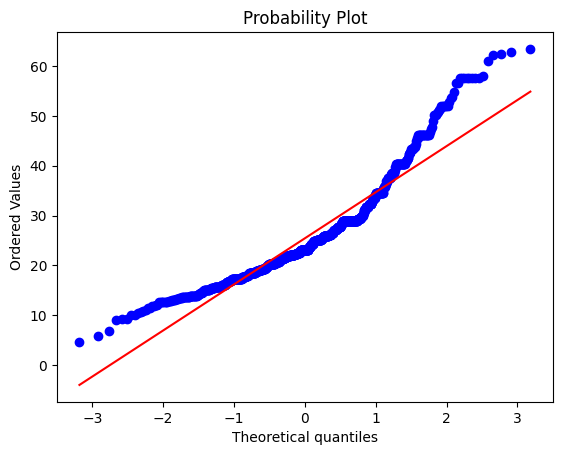

In [14]:
stats.probplot(data_at_job['Salary'], dist="norm", plot=plt)
plt.show()

In [15]:
data_at_job

,Age,Current_position,Salary,Actual_hrs,Effort,Teaching_hrs,Research_hrs,External_funding_hrs,Admin_hrs,Policy_influence,...,Follow_commands,Do_differently,Want_to_do,Done_best,Forced_to_do,Work_prospects,Physical_working_conditions,Use_of_abilities,Satisfaction_w_salary,Overall_satisfaction
0,35.0,8.0,22.788462,45.0,112.500000,NaN,35.0,10.0,NaN,1.0,...,4.0,3.0,3.0,4.0,2.0,3.0,4.0,4.0,3.0,3.0
1,51.0,13.0,20.192308,40.0,100.000000,0.0,10.0,10.0,80.0,2.0,...,4.0,5.0,1.0,3.0,5.0,4.0,3.0,1.0,1.0,2.0
2,34.0,8.0,17.884615,50.0,125.000000,15.0,30.0,2.0,5.0,3.0,...,3.0,2.0,4.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0
3,29.0,11.0,26.373626,35.0,100.000000,1.0,20.0,9.0,5.0,1.0,...,3.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,3.0
4,41.0,10.0,21.923077,40.0,100.000000,35.0,5.0,0.0,5.0,3.0,...,1.0,2.0,3.0,4.0,1.0,3.0,4.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,40.0,11.0,25.961538,40.0,100.000000,20.0,20.0,NaN,NaN,1.0,...,1.0,2.0,5.0,5.0,1.0,5.0,1.0,5.0,4.0,4.0
942,27.0,9.0,18.907500,35.0,116.666667,0.0,25.0,1.0,4.0,2.0,...,4.0,5.0,2.0,2.0,4.0,4.0,4.0,2.0,1.0,2.0
943,27.0,9.0,22.061538,30.0,100.000000,0.0,25.0,0.0,5.0,1.0,...,4.0,2.0,4.0,5.0,1.0,2.0,2.0,4.0,3.0,4.0
944,28.0,9.0,13.461538,42.0,116.666667,2.0,40.0,0.0,0.0,1.0,...,5.0,4.0,2.0,1.0,4.0,1.0,2.0,2.0,1.0,2.0


In [16]:
np.sort(data_at_job['Current_position'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])

In [17]:
data_at_job

,Age,Current_position,Salary,Actual_hrs,Effort,Teaching_hrs,Research_hrs,External_funding_hrs,Admin_hrs,Policy_influence,...,Follow_commands,Do_differently,Want_to_do,Done_best,Forced_to_do,Work_prospects,Physical_working_conditions,Use_of_abilities,Satisfaction_w_salary,Overall_satisfaction
0,35.0,8.0,22.788462,45.0,112.500000,NaN,35.0,10.0,NaN,1.0,...,4.0,3.0,3.0,4.0,2.0,3.0,4.0,4.0,3.0,3.0
1,51.0,13.0,20.192308,40.0,100.000000,0.0,10.0,10.0,80.0,2.0,...,4.0,5.0,1.0,3.0,5.0,4.0,3.0,1.0,1.0,2.0
2,34.0,8.0,17.884615,50.0,125.000000,15.0,30.0,2.0,5.0,3.0,...,3.0,2.0,4.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0
3,29.0,11.0,26.373626,35.0,100.000000,1.0,20.0,9.0,5.0,1.0,...,3.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,3.0
4,41.0,10.0,21.923077,40.0,100.000000,35.0,5.0,0.0,5.0,3.0,...,1.0,2.0,3.0,4.0,1.0,3.0,4.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,40.0,11.0,25.961538,40.0,100.000000,20.0,20.0,NaN,NaN,1.0,...,1.0,2.0,5.0,5.0,1.0,5.0,1.0,5.0,4.0,4.0
942,27.0,9.0,18.907500,35.0,116.666667,0.0,25.0,1.0,4.0,2.0,...,4.0,5.0,2.0,2.0,4.0,4.0,4.0,2.0,1.0,2.0
943,27.0,9.0,22.061538,30.0,100.000000,0.0,25.0,0.0,5.0,1.0,...,4.0,2.0,4.0,5.0,1.0,2.0,2.0,4.0,3.0,4.0
944,28.0,9.0,13.461538,42.0,116.666667,2.0,40.0,0.0,0.0,1.0,...,5.0,4.0,2.0,1.0,4.0,1.0,2.0,2.0,1.0,2.0


In [18]:
## Interpolating the missing answer data using averages from each job position:
data_at_job_interpolated = data_at_job
data_at_job_interpolated.columns

for i in range(len(data_at_job_interpolated.columns)-3):
  for j in np.sort(data_at_job_interpolated['Current_position'].unique()):
    interpolation = data_at_job_interpolated[data_at_job_interpolated.columns[i+2]][data_at_job_interpolated['Current_position']== j].mean()
    print('Interpolated Value:', interpolation)
    data_at_job_interpolated[data_at_job_interpolated.columns[i+2]][(data_at_job_interpolated[data_at_job_interpolated.columns[i+2]].isna())
    & (data_at_job_interpolated['Current_position']== j)] = interpolation

data_at_job_interpolated.to_csv('data_at_job_interpolated.csv')
data_at_job_interpolated



Interpolated Value: 20.067036578088498
Interpolated Value: 41.381715958294905
Interpolated Value: 36.06349532820121
Interpolated Value: 29.13871705217858
Interpolated Value: 38.9467032967033
Interpolated Value: 33.58947173516139
Interpolated Value: 32.728575174825174
Interpolated Value: 26.590242448900938
Interpolated Value: 21.2324724750927
Interpolated Value: 25.543949266777176
Interpolated Value: 21.390911119408155
Interpolated Value: 29.87210326941991
Interpolated Value: 21.769152732654753
Interpolated Value: 35.611111111111114
Interpolated Value: 48.14912280701754
Interpolated Value: 41.38235294117647
Interpolated Value: 45.51136363636363
Interpolated Value: 49.333333333333336
Interpolated Value: 46.62068965517241
Interpolated Value: 46.11363636363637
Interpolated Value: 43.1042735042735
Interpolated Value: 39.27717391304348
Interpolated Value: 37.55625
Interpolated Value: 36.42338709677419
Interpolated Value: 25.348837209302324
Interpolated Value: 32.265625
Interpolated Value: 10

/tmp/ipython-input-468727145.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_at_job_interpolated[data_at_job_interpolated.columns[i+2]][(data_at_job_interpolated[data_at_job_interpolated.columns[i+2]].isna())
/tmp/ipython-input-4687

Interpolated Value: 3.4563106796116503
Interpolated Value: 3.403225806451613
Interpolated Value: 3.883720930232558
Interpolated Value: 3.625
Interpolated Value: 3.3383838383838382
Interpolated Value: 2.4210526315789473
Interpolated Value: 2.9411764705882355
Interpolated Value: 3.25
Interpolated Value: 2.3333333333333335
Interpolated Value: 2.5517241379310347
Interpolated Value: 2.727272727272727
Interpolated Value: 2.7948717948717947
Interpolated Value: 3.2753623188405796
Interpolated Value: 2.644230769230769
Interpolated Value: 3.1774193548387095
Interpolated Value: 2.4651162790697674
Interpolated Value: 3.1875
Interpolated Value: 3.388888888888889
Interpolated Value: 3.0350877192982457
Interpolated Value: 3.5294117647058822
Interpolated Value: 3.372093023255814
Interpolated Value: 3.25
Interpolated Value: 3.3793103448275863
Interpolated Value: 3.4545454545454546
Interpolated Value: 3.3846153846153846
Interpolated Value: 3.2681159420289854
Interpolated Value: 3.4174757281553396
Interp

/tmp/ipython-input-468727145.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data_at_job_interpolated[data_at_job_interpolated.columns[i+2]][(data_at_job_interpolated[data_at_job_interpolated.columns[i+2]].isna())
/tmp/ipython-input-4687

,Age,Current_position,Salary,Actual_hrs,Effort,Teaching_hrs,Research_hrs,External_funding_hrs,Admin_hrs,Policy_influence,...,Follow_commands,Do_differently,Want_to_do,Done_best,Forced_to_do,Work_prospects,Physical_working_conditions,Use_of_abilities,Satisfaction_w_salary,Overall_satisfaction
0,35.0,8.0,22.788462,45.0,112.500000,9.043103,35.0,10.000000,7.025862,1.0,...,4.0,3.0,3.0,4.0,2.0,3.0,4.0,4.0,3.0,3.0
1,51.0,13.0,20.192308,40.0,100.000000,0.000000,10.0,10.000000,80.000000,2.0,...,4.0,5.0,1.0,3.0,5.0,4.0,3.0,1.0,1.0,2.0
2,34.0,8.0,17.884615,50.0,125.000000,15.000000,30.0,2.000000,5.000000,3.0,...,3.0,2.0,4.0,4.0,2.0,2.0,5.0,4.0,4.0,4.0
3,29.0,11.0,26.373626,35.0,100.000000,1.000000,20.0,9.000000,5.000000,1.0,...,3.0,4.0,3.0,4.0,4.0,3.0,2.0,3.0,3.0,3.0
4,41.0,10.0,21.923077,40.0,100.000000,35.000000,5.0,0.000000,5.000000,3.0,...,1.0,2.0,3.0,4.0,1.0,3.0,4.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,40.0,11.0,25.961538,40.0,100.000000,20.000000,20.0,6.452174,6.046610,1.0,...,1.0,2.0,5.0,5.0,1.0,5.0,1.0,5.0,4.0,4.0
942,27.0,9.0,18.907500,35.0,116.666667,0.000000,25.0,1.000000,4.000000,2.0,...,4.0,5.0,2.0,2.0,4.0,4.0,4.0,2.0,1.0,2.0
943,27.0,9.0,22.061538,30.0,100.000000,0.000000,25.0,0.000000,5.000000,1.0,...,4.0,2.0,4.0,5.0,1.0,2.0,2.0,4.0,3.0,4.0
944,28.0,9.0,13.461538,42.0,116.666667,2.000000,40.0,0.000000,0.000000,1.0,...,5.0,4.0,2.0,1.0,4.0,1.0,2.0,2.0,1.0,2.0


In [19]:
## PERCEIVED AUTONOMY:
inversion_list = ['Follow_commands', ## TO INVERT
                  'Do_differently', ## TO INVERT
                  'Forced_to_do'] ## TO INVERT

data_at_job_w_inversion = data_at_job_interpolated


for col in inversion_list:
  print('Before:', col, ":", np.sort(data_at_job_w_inversion[col].unique()))
  data_at_job_w_inversion[col] = max(data_at_job_w_inversion[col])+1 - data_at_job_w_inversion[col]
  print(col, ":", np.sort(data_at_job_w_inversion[col].unique()))

data_at_job_w_inversion.to_csv('data_at_job_w_inversion.csv')
data_at_job_w_inversion



Before: Follow_commands : [1. 2. 3. 4. 5.]
Follow_commands : [1. 2. 3. 4. 5.]
Before: Do_differently : [1.         2.         3.         3.25       3.37209302 3.41747573
 4.         5.        ]
Do_differently : [1.         2.         2.58252427 2.62790698 2.75       3.
 4.         5.        ]
Before: Forced_to_do : [1.         2.         2.38834951 2.7810219  3.         4.
 5.        ]
Forced_to_do : [1.         2.         3.         3.2189781  3.61165049 4.
 5.        ]


,Age,Current_position,Salary,Actual_hrs,Effort,Teaching_hrs,Research_hrs,External_funding_hrs,Admin_hrs,Policy_influence,...,Follow_commands,Do_differently,Want_to_do,Done_best,Forced_to_do,Work_prospects,Physical_working_conditions,Use_of_abilities,Satisfaction_w_salary,Overall_satisfaction
0,35.0,8.0,22.788462,45.0,112.500000,9.043103,35.0,10.000000,7.025862,1.0,...,2.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0
1,51.0,13.0,20.192308,40.0,100.000000,0.000000,10.0,10.000000,80.000000,2.0,...,2.0,1.0,1.0,3.0,1.0,4.0,3.0,1.0,1.0,2.0
2,34.0,8.0,17.884615,50.0,125.000000,15.000000,30.0,2.000000,5.000000,3.0,...,3.0,4.0,4.0,4.0,4.0,2.0,5.0,4.0,4.0,4.0
3,29.0,11.0,26.373626,35.0,100.000000,1.000000,20.0,9.000000,5.000000,1.0,...,3.0,2.0,3.0,4.0,2.0,3.0,2.0,3.0,3.0,3.0
4,41.0,10.0,21.923077,40.0,100.000000,35.000000,5.0,0.000000,5.000000,3.0,...,5.0,4.0,3.0,4.0,5.0,3.0,4.0,2.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,40.0,11.0,25.961538,40.0,100.000000,20.000000,20.0,6.452174,6.046610,1.0,...,5.0,4.0,5.0,5.0,5.0,5.0,1.0,5.0,4.0,4.0
942,27.0,9.0,18.907500,35.0,116.666667,0.000000,25.0,1.000000,4.000000,2.0,...,2.0,1.0,2.0,2.0,2.0,4.0,4.0,2.0,1.0,2.0
943,27.0,9.0,22.061538,30.0,100.000000,0.000000,25.0,0.000000,5.000000,1.0,...,2.0,4.0,4.0,5.0,5.0,2.0,2.0,4.0,3.0,4.0
944,28.0,9.0,13.461538,42.0,116.666667,2.000000,40.0,0.000000,0.000000,1.0,...,1.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0


In [20]:
data_at_formatted = data_at_job_w_inversion

data_at_formatted = data_at_formatted.dropna(subset = ['Overall_satisfaction']).reset_index(drop=True)


## Calculating percentage hours for teaching and research:
data_at_formatted['Teaching_percent'] = data_at_formatted['Teaching_hrs']/data_at_formatted[['Teaching_hrs', 'Research_hrs',
                                                                                             'External_funding_hrs', 'Admin_hrs']].sum(axis=1)*100
data_at_formatted['Research_percent'] = data_at_formatted['Research_hrs']/data_at_formatted[['Teaching_hrs', 'Research_hrs',
                                                                                             'External_funding_hrs', 'Admin_hrs']].sum(axis=1)*100
data_at_formatted = data_at_formatted.drop(['Teaching_hrs', 'Research_hrs', 'External_funding_hrs', 'Admin_hrs'], axis=1)


## Calculating average score for Academic Resources:
data_at_formatted['Academic_Resources'] = data_at_formatted[['Acad_res_facility', 'Acad_res_equip', 'Acad_res_lit',
                                                             'Acad_res_support', 'Acad_res_PD', 'Acad_res_funding']].mean(axis=1)
data_at_formatted = data_at_formatted.drop(['Acad_res_facility', 'Acad_res_equip', 'Acad_res_lit',
                        'Acad_res_support', 'Acad_res_PD', 'Acad_res_funding'], axis=1)


## Calculating average score for Perceived Autonomy:
data_at_formatted['Perceived_Autonomy'] = data_at_formatted[['Be_myself', "Follow_commands", 'Do_differently',
                                                             'Want_to_do', 'Done_best', 'Forced_to_do']].mean(axis=1)
data_at_formatted = data_at_formatted.drop(['Be_myself', "Follow_commands", 'Do_differently',
                        'Want_to_do', 'Done_best', 'Forced_to_do'], axis=1)


## Calculating average score for Leadership quality:
# data_at_formatted['Leadership_quality'] = data_at_formatted[['Development_opportunities', 'Prioritizes_satisfaction',
#                                                              'Work_planning', 'Solving_conflicts']].mean(axis=1)
# data_at_formatted = data_at_formatted.drop(['Development_opportunities', 'Prioritizes_satisfaction',
#                                                              'Work_planning', 'Solving_conflicts'],axis=1)


## Calculating average score for sense of community:
# data_at_formatted['Sense_of_community'] = data_at_formatted[['Good_atmosphere', 'Good_cooperation',
#                                                              'Part_of_community']].mean(axis=1)
# data_at_formatted = data_at_formatted.drop(['Good_atmosphere', 'Good_cooperation', 'Part_of_community'], axis=1)

## Calculating average score for job satisfaction:
data_at_formatted['Job_satisfaction'] = data_at_formatted[['Work_prospects', 'Physical_working_conditions',
                                                           'Use_of_abilities', 'Satisfaction_w_salary',
                                                           'Overall_satisfaction']].mean(axis=1)
data_at_formatted = data_at_formatted.drop(['Work_prospects', 'Physical_working_conditions',
                        'Use_of_abilities', 'Satisfaction_w_salary',
                        'Overall_satisfaction'],axis=1)


data_at_formatted.to_csv('data_at_formatted.csv')
print(data_at_formatted.columns.tolist())

['Age', 'Current_position', 'Salary', 'Actual_hrs', 'Effort', 'Policy_influence', 'Teaching_percent', 'Research_percent', 'Academic_Resources', 'Perceived_Autonomy', 'Job_satisfaction']


In [21]:
data_at_formatted

,Age,Current_position,Salary,Actual_hrs,Effort,Policy_influence,Teaching_percent,Research_percent,Academic_Resources,Perceived_Autonomy,Job_satisfaction
0,35.0,8.0,22.788462,45.0,112.500000,1.0,14.808018,57.312253,3.333333,3.333333,3.4
1,51.0,13.0,20.192308,40.0,100.000000,2.0,0.000000,10.000000,1.500000,2.166667,2.2
2,34.0,8.0,17.884615,50.0,125.000000,3.0,28.846154,57.692308,3.500000,3.833333,3.8
3,29.0,11.0,26.373626,35.0,100.000000,1.0,2.857143,57.142857,3.500000,3.166667,2.8
4,41.0,10.0,21.923077,40.0,100.000000,3.0,77.777778,11.111111,4.333333,4.333333,2.8
...,...,...,...,...,...,...,...,...,...,...,...
940,40.0,11.0,25.961538,40.0,100.000000,1.0,38.096120,38.096120,2.333333,4.833333,3.8
941,27.0,9.0,18.907500,35.0,116.666667,2.0,0.000000,83.333333,4.333333,1.666667,2.6
942,27.0,9.0,22.061538,30.0,100.000000,1.0,0.000000,83.333333,3.500000,4.166667,3.0
943,28.0,9.0,13.461538,42.0,116.666667,1.0,4.761905,95.238095,2.333333,1.500000,1.6


In [22]:
## Taking only academic positions:

# data_at_formatted_academic = data_at_formatted[~data_at_formatted['Current_position'].isin([1., 13.])]

data_at_formatted_academic = data_at_formatted[data_at_formatted['Current_position'].isin([2., 3., 4., 5., 6., 7., 8., 9.])]

np.sort(data_at_formatted_academic['Current_position'].unique())

data_at_formatted_academic['Current_position'].value_counts().sort_index()

,count
Current_position,
2.0,57
3.0,17
4.0,44
5.0,21
6.0,29
7.0,22
8.0,117
9.0,137


In [23]:
## Inverting the categorical values so that seniority is in increasing order:

data_at_formatted_academic['Current_position'] = 11. - data_at_formatted_academic['Current_position']
data_at_formatted_academic.loc[data_at_formatted_academic['Current_position'] > 6, 'Current_position'] = 6
data_at_formatted_academic['Current_position'].value_counts().sort_index()

/tmp/ipython-input-4090973165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_at_formatted_academic['Current_position'] = 11. - data_at_formatted_academic['Current_position']


,count
Current_position,
2.0,137
3.0,117
4.0,22
5.0,29
6.0,139


In [24]:
data_at_formatted_academic.to_csv('data_at_formatted_seniority.csv')
data_at_formatted_academic

,Age,Current_position,Salary,Actual_hrs,Effort,Policy_influence,Teaching_percent,Research_percent,Academic_Resources,Perceived_Autonomy,Job_satisfaction
0,35.0,3.0,22.788462,45.0,112.500000,1.0,14.808018,57.312253,3.333333,3.333333,3.4
2,34.0,3.0,17.884615,50.0,125.000000,3.0,28.846154,57.692308,3.500000,3.833333,3.8
6,26.0,2.0,21.758242,35.0,100.000000,2.0,11.428571,80.000000,4.166667,3.500000,4.6
7,36.0,3.0,28.846154,50.0,125.000000,1.0,16.666667,50.000000,2.666667,2.500000,2.0
8,29.0,3.0,28.846154,40.0,100.000000,1.0,7.500000,87.500000,4.333333,4.333333,4.2
...,...,...,...,...,...,...,...,...,...,...,...
819,42.0,6.0,28.846154,52.5,131.250000,3.0,34.482759,34.482759,4.500000,4.000000,4.8
941,27.0,2.0,18.907500,35.0,116.666667,2.0,0.000000,83.333333,4.333333,1.666667,2.6
942,27.0,2.0,22.061538,30.0,100.000000,1.0,0.000000,83.333333,3.500000,4.166667,3.0
943,28.0,2.0,13.461538,42.0,116.666667,1.0,4.761905,95.238095,2.333333,1.500000,1.6


Text(0.5, 1.0, 'Austrian Positions')

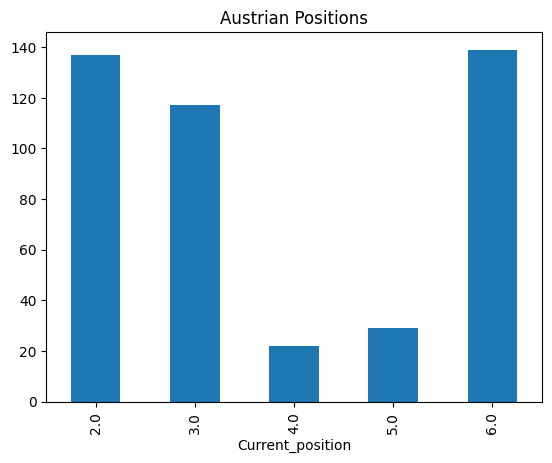

In [25]:
data_at_formatted_academic['Current_position'].value_counts().sort_index().plot(kind='bar')
plt.title('Austrian Positions')

In [26]:
## Creating dummy variables for the categorical variables Current Position, Contract Duration, and Leadership Position:

data_at_formatted_academic_w_dummies = pd.get_dummies(data_at_formatted_academic, columns = ['Current_position'], drop_first=True) #'Contract_duration', 'Leadership_position'

data_at_formatted_academic_w_dummies = data_at_formatted_academic_w_dummies.dropna().reset_index(drop=True)

data_at_formatted_academic_w_dummies = data_at_formatted_academic_w_dummies.astype(float)

Current_position_dummy_cols = [col for col in data_at_formatted_academic_w_dummies.columns if 'Current_position' in col]
Working_condition_cols = [col for col in data_at_formatted_academic_w_dummies.columns if col not in ['Job_satisfaction']+['Age']+Current_position_dummy_cols]

## Calculating the interaction terms for Age moderator:
for col in Working_condition_cols:
  data_at_formatted_academic_w_dummies[col+'_mod_Age'] = data_at_formatted_academic_w_dummies[col] * data_at_formatted_academic_w_dummies['Age']

# data_at_formatted_academic_w_dummies = data_at_formatted_academic_w_dummies.drop(['Age_mod_Age'], axis=1)

data_at_formatted_academic_w_dummies.to_csv('data_at_formatted_academic_w_dummies.csv')

print(data_at_formatted_academic_w_dummies.columns.tolist())
print(np.shape(data_at_formatted_academic_w_dummies))

['Age', 'Salary', 'Actual_hrs', 'Effort', 'Policy_influence', 'Teaching_percent', 'Research_percent', 'Academic_Resources', 'Perceived_Autonomy', 'Job_satisfaction', 'Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0', 'Salary_mod_Age', 'Actual_hrs_mod_Age', 'Effort_mod_Age', 'Policy_influence_mod_Age', 'Teaching_percent_mod_Age', 'Research_percent_mod_Age', 'Academic_Resources_mod_Age', 'Perceived_Autonomy_mod_Age']
(444, 22)


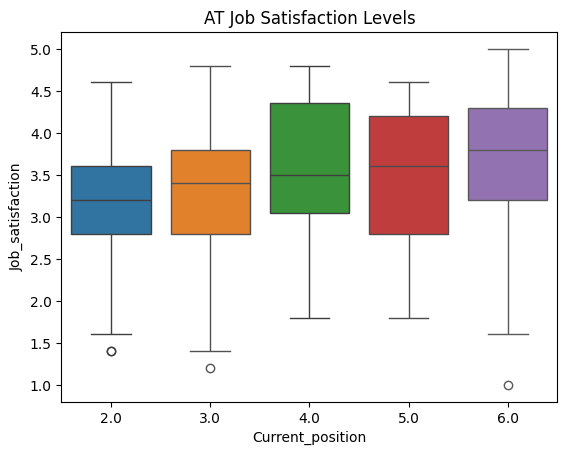

,Current Position,Job Satisfaction,Confidence Interval
0,2.0,3.195620,"[1.680, 4.600]"
1,3.0,3.235897,"[1.760, 4.400]"
2,4.0,3.554545,"[2.115, 4.800]"
3,5.0,3.533005,"[2.360, 4.600]"
4,6.0,3.704599,"[2.090, 5.000]"


In [27]:
satisfaction = pd.DataFrame()
pos = []
satis = []
pbci = []

plt.figure()
for value in np.sort(data_at_formatted_academic['Current_position'].unique()):
  pos.append(value)
  data = data_at_formatted_academic[data_at_formatted_academic['Current_position']==value]
  satis.append(data['Job_satisfaction'].mean())
  lbound = np.percentile(data['Job_satisfaction'], 2.5)
  ubound = np.percentile(data['Job_satisfaction'], 97.5)
  pbci.append(f'[{lbound:.3f}, {ubound:.3f}]')
  sns.boxplot(x='Current_position', y = 'Job_satisfaction', data = data)
plt.title('AT Job Satisfaction Levels')
plt.show()



satisfaction['Current Position'] = pos
satisfaction['Job Satisfaction'] = satis
satisfaction['Confidence Interval'] = pbci
satisfaction

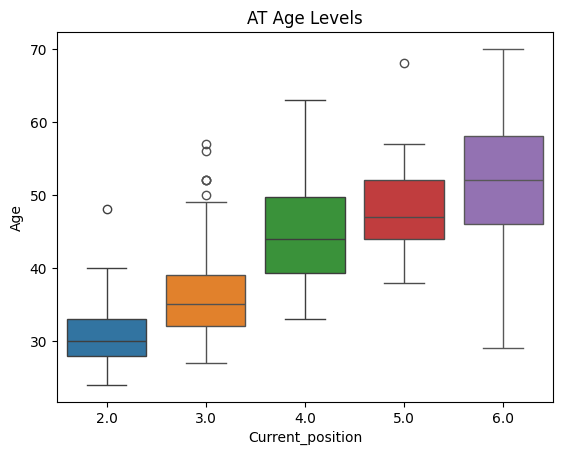

In [28]:
plt.figure()
for value in np.sort(data_at_formatted_academic['Current_position'].unique()):
  data = data_at_formatted_academic[data_at_formatted_academic['Current_position']==value]
  sns.boxplot(x='Current_position', y = 'Age', data = data)
plt.title('AT Age Levels')
plt.show()

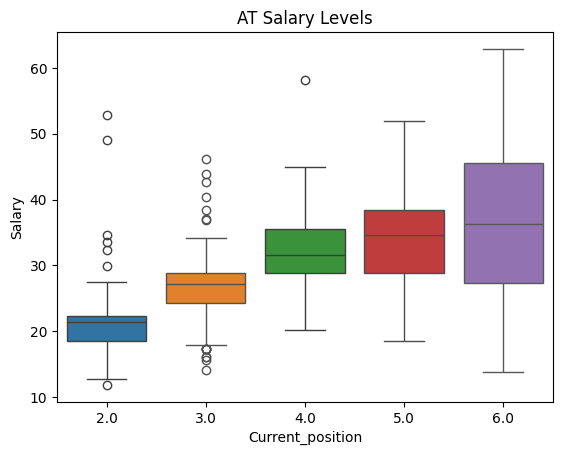

In [29]:
plt.figure()
for value in np.sort(data_at_formatted_academic['Current_position'].unique()):
  data = data_at_formatted_academic[data_at_formatted_academic['Current_position']==value]
  sns.boxplot(x='Current_position', y = 'Salary', data = data)
plt.title('AT Salary Levels')
plt.show()

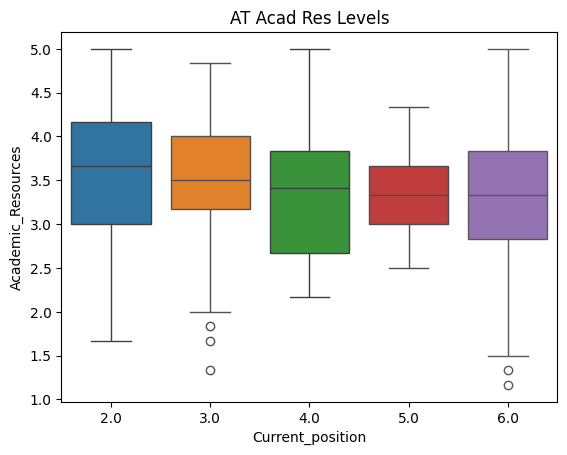

In [30]:
plt.figure()
for value in np.sort(data_at_formatted_academic['Current_position'].unique()):
  data = data_at_formatted_academic[data_at_formatted_academic['Current_position']==value]
  sns.boxplot(x='Current_position', y = 'Academic_Resources', data = data)
plt.title('AT Acad Res Levels')
plt.show()

##Correlations and VIF Multicollinearity:

Text(0.5, 1.0, 'AT Correlation Heatmap')

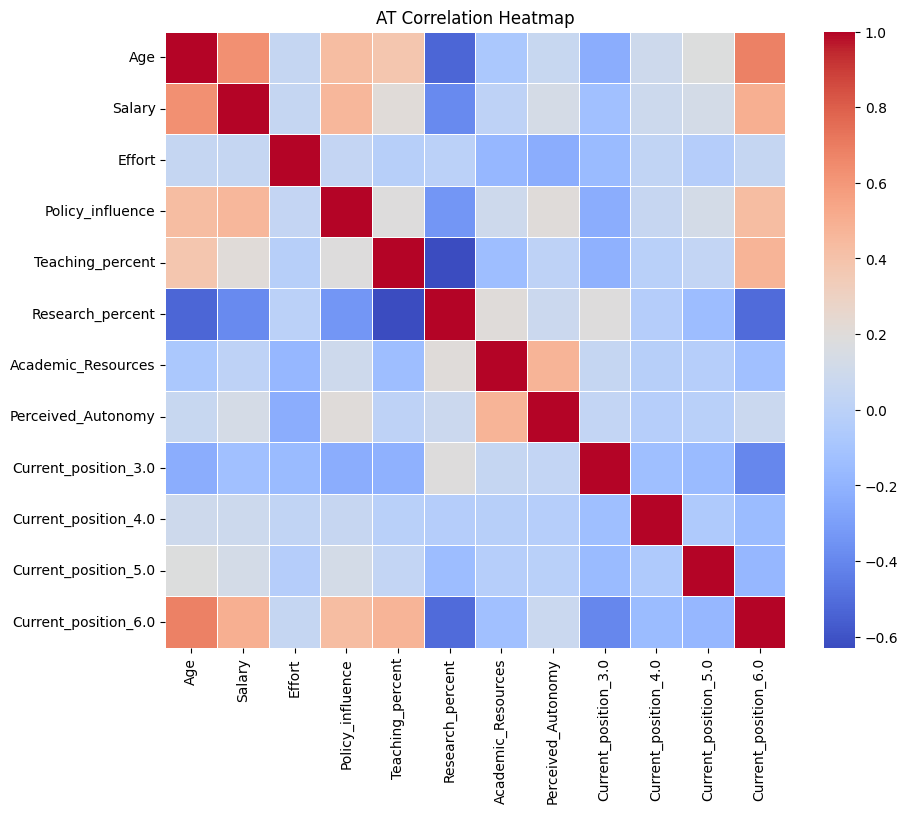

In [31]:
corr_cols = [col for col in data_at_formatted_academic_w_dummies.columns if 'mod_Age' not in col
             and 'Job_satisfaction' not in col and 'Actual_hrs' not in col]
correlations = data_at_formatted_academic_w_dummies[corr_cols].corr()

plt.figure(figsize=(10, 8)) #, dpi=600)
sns.heatmap(correlations, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('AT Correlation Heatmap')

In [32]:
## Performing Variance Inflation Factor (VIF) analysis of the dataset:

Current_position_dummy_cols = [col for col in data_at_formatted_academic_w_dummies.columns if 'Current_position' in col and 'mod_Age' not in col]
## Taking the moderation coefficients separately:
Moderation_cols = [col for col in data_at_formatted_academic_w_dummies.columns if 'mod_Age' in col] # and 'Job_satisfaction' not in col]
## Taking the remaining variables for working conditions:
Working_condition_cols = [col for col in data_at_formatted_academic_w_dummies.columns if col not in ['Job_satisfaction']+['Age']+Current_position_dummy_cols+Moderation_cols]

for cols in [Current_position_dummy_cols, Working_condition_cols, Moderation_cols]:
  if cols == Current_position_dummy_cols:
    print('Current Position:')
  elif cols == Working_condition_cols:
    print('Working Conditions:')
  elif cols == Moderation_cols:
    print('Age-Moderated Working Conditions:')
  X = data_at_formatted_academic_w_dummies[cols].copy()
  X_const = add_constant(X)
  vif_data = pd.DataFrame()
  vif_data['Variable'] = X_const.columns
  vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

  print(vif_data)
  print('----------------------------------------')

Current Position:
               Variable       VIF
0                 const  3.240876
1  Current_position_3.0  1.365457
2  Current_position_4.0  1.103078
3  Current_position_5.0  1.132538
4  Current_position_6.0  1.383902
----------------------------------------
Working Conditions:
             Variable        VIF
0               const  92.308276
1              Salary   1.504522
2          Actual_hrs   2.034510
3              Effort   1.853372
4    Policy_influence   1.413630
5    Teaching_percent   1.699600
6    Research_percent   2.053094
7  Academic_Resources   1.374201
8  Perceived_Autonomy   1.418289
----------------------------------------
Age-Moderated Working Conditions:
                     Variable        VIF
0                       const  18.809248
1              Salary_mod_Age   3.412574
2          Actual_hrs_mod_Age   6.865630
3              Effort_mod_Age   7.042506
4    Policy_influence_mod_Age   2.408866
5    Teaching_percent_mod_Age   2.002075
6    Research_percent_mod

In [33]:
data_at_formatted_academic_w_dummies['Job_satisfaction'].unique()

array([3.4       , 3.8       , 4.6       , 2.        , 4.2       ,
       3.        , 2.2       , 3.6       , 2.4       , 4.        ,
       3.2       , 2.6       , 1.8       , 4.4       , 4.8       ,
       2.8       , 4.25714286, 1.        , 4.15      , 5.        ,
       1.4       , 1.2       , 1.6       , 3.4540146 , 3.5459854 ,
       3.18928571])

## Calculating Cronbach's Alpha for the combined factors:

In [34]:
def Cronbach_alpha_func(data, label):
  col_nr = data.shape[1]

  item_variances = np.var(data, axis=0, ddof=1)
  total_var = np.var(np.sum(data, axis=1), ddof=1)
  alpha_cronbach = (col_nr/(col_nr-1))*(1-(np.sum(item_variances)/total_var))

  print(f'{label} Cronbach Alpha:', alpha_cronbach)
  return alpha_cronbach

In [35]:
## Academic Resources:

data_at_for_alpha_academic = data_at_job_w_inversion[(data_at_job_w_inversion['Current_position'].isin([2., 3., 4., 5., 6., 7., 8., 9.]))] # &
                                                    #  (data_at_job_w_inversion['Contract_duration']<6) &
                                                    #  (data_at_job_w_inversion['Leadership_position']<4)].dropna()
## Performing inversion:
# data_at_for_alpha_academic['Current_position'] = 11. - data_at_for_alpha_academic['Current_position']

print(len(data_at_for_alpha_academic))

academic_resources_for_alpha = np.asarray(data_at_for_alpha_academic[['Acad_res_facility', 'Acad_res_equip', 'Acad_res_lit',
                         'Acad_res_support', 'Acad_res_PD', 'Acad_res_funding']])

perceived_autonomy_for_alpha = np.asarray(data_at_for_alpha_academic[['Be_myself', "Follow_commands", 'Do_differently',
                                                             'Want_to_do', 'Done_best', 'Forced_to_do']])

# leadership_quality_for_alpha = np.asarray(data_at_for_alpha_academic[['Development_opportunities', 'Prioritizes_satisfaction',
#                                                              'Work_planning', 'Solving_conflicts']])

# sense_of_community_for_alpha = np.asarray(data_at_for_alpha_academic[['Good_atmosphere', 'Good_cooperation', 'Part_of_community']])

job_satisfaction_for_alpha = np.asarray(data_at_for_alpha_academic[['Work_prospects', 'Physical_working_conditions',
                                                                      'Use_of_abilities', 'Satisfaction_w_salary',
                                                                      'Overall_satisfaction']].dropna())


acad_res_cron_alpha = Cronbach_alpha_func(academic_resources_for_alpha, 'Academic Resources')
perc_auton_cron_alpha = Cronbach_alpha_func(perceived_autonomy_for_alpha, 'Perceived Autonomy')
# lead_qual_cron_alpha = Cronbach_alpha_func(leadership_quality_for_alpha, 'Leadership Quality')
# sens_comm_cron_alpha = Cronbach_alpha_func(sense_of_community_for_alpha, 'Sense of Community')
print('---------------------')
job_sat_cron_alpha = Cronbach_alpha_func(job_satisfaction_for_alpha, 'Job Satisfaction')





445
Academic Resources Cronbach Alpha: 0.7762949478533535
Perceived Autonomy Cronbach Alpha: 0.873410366616401
---------------------
Job Satisfaction Cronbach Alpha: 0.7603269724102166


## Bayesian SEM (MCMC) with Age Moderation:

In [ ]:
## Defining the current position columns:
Current_position_3 = data_at_formatted_academic_w_dummies['Current_position_3.0']
Current_position_4 = data_at_formatted_academic_w_dummies['Current_position_4.0']
Current_position_5 = data_at_formatted_academic_w_dummies['Current_position_5.0']
Current_position_6 = data_at_formatted_academic_w_dummies['Current_position_6.0']
## Defining the working condition columns:
Salary = data_at_formatted_academic_w_dummies['Salary']
Effort = data_at_formatted_academic_w_dummies['Effort']
Teaching_percent = data_at_formatted_academic_w_dummies['Teaching_percent']
Research_percent = data_at_formatted_academic_w_dummies['Research_percent']
Policy_influence = data_at_formatted_academic_w_dummies['Policy_influence']
Academic_Resources = data_at_formatted_academic_w_dummies['Academic_Resources']
Perceived_Autonomy = data_at_formatted_academic_w_dummies['Perceived_Autonomy']
## Defining the Age column:
Age = data_at_formatted_academic_w_dummies['Age']
## Defining the Job Satisfaction column:
Job_satisfaction = data_at_formatted_academic_w_dummies['Job_satisfaction']

In [ ]:
## Model based on the mediation model outlined here: https://www.pymc.io/projects/examples/en/stable/case_studies/mediation_analysis.html

def mediation_model(Current_position_3, Current_position_4, Current_position_5, Current_position_6, Salary, Effort,
                    Teaching_percent, Research_percent, Policy_influence, Academic_Resources,
                    Perceived_Autonomy, Age, Job_satisfaction):
    with pm.Model() as model:
        ## Setting up the job position parameters:
        Current_position_3 = pm.Data("Current_position_3", Current_position_3, dims="obs_id")
        Current_position_4 = pm.Data("Current_position_4", Current_position_4, dims="obs_id")
        Current_position_5 = pm.Data("Current_position_5", Current_position_5, dims="obs_id")
        Current_position_6 = pm.Data("Current_position_6", Current_position_6, dims="obs_id")
        ## Setting up the Job Satisfaction response variable:
        Job_satisfaction = pm.Data("Job_satisfaction", Job_satisfaction, dims="obs_id")
        ## Setting up the mediation coefficients (Working Conditions):
        Salary = pm.Data("Salary", Salary, dims="obs_id")
        Effort = pm.Data("Effort", Effort, dims="obs_id")
        Teaching_percent = pm.Data("Teaching_percent", Teaching_percent, dims="obs_id")
        Research_percent = pm.Data("Research_percent", Research_percent, dims="obs_id")
        Policy_influence = pm.Data("Policy_influence", Policy_influence, dims="obs_id")
        Academic_Resources = pm.Data("Academic_Resources", Academic_Resources, dims="obs_id")
        Perceived_Autonomy = pm.Data("Perceived_Autonomy", Perceived_Autonomy, dims="obs_id")

        ## Setting up the Moderator (Age):
        Age = pm.Data('Age', Age, dims="obs_id")

        # intercept priors
        iy = pm.Normal("iy", mu=0, sigma=10)
        im1 = pm.Normal("im1", mu=0, sigma=10) ## for Salary
        im2 = pm.Normal("im2", mu=0, sigma=10) ## for Effort
        im3 = pm.Normal("im3", mu=0, sigma=10) ## for Teaching %
        im4 = pm.Normal("im4", mu=0, sigma=10) ## for Research %
        im5 = pm.Normal("im5", mu=0, sigma=10) ## for Policy Influence
        im6 = pm.Normal("im6", mu=0, sigma=10) ## for Academic Resources
        im7 = pm.Normal("im7", mu=0, sigma=10) ## for Perceived Autonomy

        # Working condition coefficient priors:
        a11 = pm.Normal("a11", mu=0, sigma=1) ## for Salary ~ Position 3
        a12 = pm.Normal("a12", mu=0, sigma=1) ## for Salary ~ Position 4
        a13 = pm.Normal("a13", mu=0, sigma=1) ## for Salary ~ Position 5
        a14 = pm.Normal("a14", mu=0, sigma=1) ## for Salary ~ Position 6

        a21 = pm.Normal("a21", mu=0, sigma=1) ## for Effort ~ Position 3
        a22 = pm.Normal("a22", mu=0, sigma=1) ## for Effort ~ Position 4
        a23 = pm.Normal("a23", mu=0, sigma=1) ## for Effort ~ Position 5
        a24 = pm.Normal("a24", mu=0, sigma=1) ## for Effort ~ Position 6

        a31 = pm.Normal("a31", mu=0, sigma=1) ## for Teaching % ~ Position 3
        a32 = pm.Normal("a32", mu=0, sigma=1) ## for Teaching % ~ Position 4
        a33 = pm.Normal("a33", mu=0, sigma=1) ## for Teaching % ~ Position 5
        a34 = pm.Normal("a34", mu=0, sigma=1) ## for Teaching % ~ Position 6

        a41 = pm.Normal("a41", mu=0, sigma=1) ## for Research % ~ Position 3
        a42 = pm.Normal("a42", mu=0, sigma=1) ## for Research % ~ Position 4
        a43 = pm.Normal("a43", mu=0, sigma=1) ## for Research % ~ Position 5
        a44 = pm.Normal("a44", mu=0, sigma=1) ## for Research % ~ Position 6

        a51 = pm.Normal("a51", mu=0, sigma=1) ## for Policy Influence ~ Position 3
        a52 = pm.Normal("a52", mu=0, sigma=1) ## for Policy Influence ~ Position 4
        a53 = pm.Normal("a53", mu=0, sigma=1) ## for Policy Influence ~ Position 5
        a54 = pm.Normal("a54", mu=0, sigma=1) ## for Policy Influence ~ Position 6

        a61 = pm.Normal("a61", mu=0, sigma=1) ## for Academic Resources ~ Position 3
        a62 = pm.Normal("a62", mu=0, sigma=1) ## for Academic Resources ~ Position 4
        a63 = pm.Normal("a63", mu=0, sigma=1) ## for Academic Resources ~ Position 5
        a64 = pm.Normal("a64", mu=0, sigma=1) ## for Academic Resources ~ Position 6

        a71 = pm.Normal("a71", mu=0, sigma=1) ## for Perceived Autonomy ~ Position 3
        a72 = pm.Normal("a72", mu=0, sigma=1) ## for Perceived Autonomy ~ Position 4
        a73 = pm.Normal("a73", mu=0, sigma=1) ## for Perceived Autonomy ~ Position 5
        a74 = pm.Normal("a74", mu=0, sigma=1) ## for Perceived Autonomy ~ Position 6


        ## Mediation coefficient oriors:
        m1 = pm.Normal("m1", mu=0, sigma=1) ## for Job Satisfaction ~ Salary
        m2 = pm.Normal("m2", mu=0, sigma=1) ## for Job Satisfaction ~ Effort
        m3 = pm.Normal("m3", mu=0, sigma=1) ## for Job Satisfaction ~ Teaching %
        m4 = pm.Normal("m4", mu=0, sigma=1) ## for Job Satisfaction ~ Research %
        m5 = pm.Normal("m5", mu=0, sigma=1) ## for Job Satisfaction ~ Policy Influence
        m6 = pm.Normal("m6", mu=0, sigma=1) ## for Job Satisfaction ~ Academic Resources
        m7 = pm.Normal("m7", mu=0, sigma=1) ## for Job Satisfaction ~ Perceived Autonomy

        ## Moderation coefficient priors:
        mod1 = pm.Normal("mod1", mu=0, sigma=1) ## for Age-Moderation on Salary
        mod2 = pm.Normal("mod2", mu=0, sigma=1) ## for Age-Moderation on Effort
        mod3 = pm.Normal("mod3", mu=0, sigma=1) ## for Age-Moderation on Teaching %
        mod4 = pm.Normal("mod4", mu=0, sigma=1) ## for Age-Moderation on Research %
        mod5 = pm.Normal("mod5", mu=0, sigma=1) ## for Age-Moderation on Policy Influence
        mod6 = pm.Normal("mod6", mu=0, sigma=1) ## for Age-Moderation on Academic Resources
        mod7 = pm.Normal("mod7", mu=0, sigma=1) ## for Age-Moderation on Perceived Autonomy

        ## Direct Path coefficient priors:
        Dir_Path1 = pm.Normal("Dir_Path1", mu=0, sigma=1) ## for Job Position 3
        Dir_Path2 = pm.Normal("Dir_Path2", mu=0, sigma=1) ## for Job Position 4
        Dir_Path3 = pm.Normal("Dir_Path3", mu=0, sigma=1) ## for Job Position 5
        Dir_Path4 = pm.Normal("Dir_Path4", mu=0, sigma=1) ## for Job Position 6
        # noise priors
        σm1 = pm.HalfCauchy("σm1", 1) ## Noise for mediation for Salary
        σm2 = pm.HalfCauchy("σm2", 1) ## Noise for mediation for Effort
        σm3 = pm.HalfCauchy("σm3", 1) ## Noise for mediation for Teaching %
        σm4 = pm.HalfCauchy("σm4", 1) ## Noise for mediation for Research %
        σm5 = pm.HalfCauchy("σm5", 1) ## Noise for mediation for Policy Influence
        σm6 = pm.HalfCauchy("σm6", 1) ## Noise for mediation for Academic Resources
        σm7 = pm.HalfCauchy("σm7", 1) ## Noise for mediation for Perceived Autonomy
        σy = pm.HalfCauchy("σy", 1) ## Noise for full model

        # likelihood
        pm.Normal("Salary_likelihood", mu=im1 + a11*Current_position_3 + a12*Current_position_4 + a13*Current_position_5 + a14*Current_position_6, sigma=σm1, observed=Salary, dims="obs_id")
        pm.Normal("Effort_likelihood", mu=im2 + a21*Current_position_3 + a22*Current_position_4 + a23*Current_position_5 + a24*Current_position_6, sigma=σm2, observed=Effort, dims="obs_id")
        pm.Normal("Teaching_likelihood", mu=im3 + a31*Current_position_3 + a32*Current_position_4 + a33*Current_position_5 + a34*Current_position_6, sigma=σm3, observed=Teaching_percent, dims="obs_id")
        pm.Normal("Research_likelihood", mu=im4 + a41*Current_position_3 + a42*Current_position_4 + a43*Current_position_5 + a44*Current_position_6, sigma=σm4, observed=Research_percent, dims="obs_id")
        pm.Normal("Policy_likelihood", mu=im5 + a51*Current_position_3 + a52*Current_position_4 + a53*Current_position_5 + a54*Current_position_6, sigma=σm5, observed=Policy_influence, dims="obs_id")
        pm.Normal("Acad_Res_likelihood", mu=im6 + a61*Current_position_3 + a62*Current_position_4 + a63*Current_position_5 + a64*Current_position_6, sigma=σm6, observed=Academic_Resources, dims="obs_id")
        pm.Normal("Autonomy_likelihood", mu=im7 + a71*Current_position_3 + a72*Current_position_4 + a73*Current_position_5 + a74*Current_position_6, sigma=σm7, observed=Perceived_Autonomy, dims="obs_id")
        pm.Normal("y_likelihood", mu=iy + m1*Salary + m2*Effort + m3*Teaching_percent +
                  m4*Research_percent + m5*Policy_influence + m6*Academic_Resources + m7*Perceived_Autonomy +
                  mod1*Salary*Age + mod2*Effort*Age + mod3*Teaching_percent*Age + mod4*Research_percent*Age +
                  mod5*Policy_influence*Age + mod6*Academic_Resources*Age + mod7*Perceived_Autonomy*Age +
                  Dir_Path1*Current_position_3 + Dir_Path2*Current_position_4 + Dir_Path3*Current_position_5 + Dir_Path4*Current_position_6,
                  sigma=σy, observed=Job_satisfaction, dims="obs_id")

        # Calculating Mediation coefficients:
        indirect_effect_salary1 = pm.Deterministic("Indirect effect (Salary) 1", a11 * m1) ## Mediation path coefficient for Job Position 3 med by Salary
        indirect_effect_salary2 = pm.Deterministic("Indirect effect (Salary) 2", a12 * m1) ## Mediation path coefficient for Job Position 4 med by Salary
        indirect_effect_salary3 = pm.Deterministic("Indirect effect (Salary) 3", a13 * m1) ## Mediation path coefficient for Job Position 5 med by Salary
        indirect_effect_salary4 = pm.Deterministic("Indirect effect (Salary) 4", a14 * m1) ## Mediation path coefficient for Job Position 6 med by Salary

        indirect_effect_effort1 = pm.Deterministic("Indirect effect (Effort) 1", a21 * m2) ## Mediation path coefficient for Job Position 3 med by Effort
        indirect_effect_effort2 = pm.Deterministic("Indirect effect (Effort) 2", a22 * m2) ## Mediation path coefficient for Job Position 4 med by Effort
        indirect_effect_effort3 = pm.Deterministic("Indirect effect (Effort) 3", a23 * m2) ## Mediation path coefficient for Job Position 5 med by Effort
        indirect_effect_effort4 = pm.Deterministic("Indirect effect (Effort) 4", a24 * m2) ## Mediation path coefficient for Job Position 6 med by Effort

        indirect_effect_teaching1 = pm.Deterministic("Indirect effect (Teaching) 1", a31 * m3) ## Mediation path coefficient for Job Position 3 med by Teaching %
        indirect_effect_teaching2 = pm.Deterministic("Indirect effect (Teaching) 2", a32 * m3) ## Mediation path coefficient for Job Position 4 med by Teaching %
        indirect_effect_teaching3 = pm.Deterministic("Indirect effect (Teaching) 3", a33 * m3) ## Mediation path coefficient for Job Position 5 med by Teaching %
        indirect_effect_teaching4 = pm.Deterministic("Indirect effect (Teaching) 4", a34 * m3) ## Mediation path coefficient for Job Position 6 med by Teaching %

        indirect_effect_research1 = pm.Deterministic("Indirect effect (Research) 1", a41 * m4) ## Mediation path coefficient for Job Position 3 med by Research %
        indirect_effect_research2 = pm.Deterministic("Indirect effect (Research) 2", a42 * m4) ## Mediation path coefficient for Job Position 4 med by Research %
        indirect_effect_research3 = pm.Deterministic("Indirect effect (Research) 3", a43 * m4) ## Mediation path coefficient for Job Position 5 med by Research %
        indirect_effect_research4 = pm.Deterministic("Indirect effect (Research) 4", a44 * m4) ## Mediation path coefficient for Job Position 6 med by Research %

        indirect_effect_policy1 = pm.Deterministic("Indirect effect (Policy) 1", a51 * m5) ## Mediation path coefficient for Job Position 3 med by Policy Influence
        indirect_effect_policy2 = pm.Deterministic("Indirect effect (Policy) 2", a52 * m5) ## Mediation path coefficient for Job Position 4 med by Policy Influence
        indirect_effect_policy3 = pm.Deterministic("Indirect effect (Policy) 3", a53 * m5) ## Mediation path coefficient for Job Position 5 med by Policy Influence
        indirect_effect_policy4 = pm.Deterministic("Indirect effect (Policy) 4", a54 * m5) ## Mediation path coefficient for Job Position 6 med by Policy Influence

        indirect_effect_resources1 = pm.Deterministic("Indirect effect (Acad Resources) 1", a61 * m6) ## Mediation path coefficient for Job Position 3 med by Academic Resources
        indirect_effect_resources2 = pm.Deterministic("Indirect effect (Acad Resources) 2", a62 * m6) ## Mediation path coefficient for Job Position 4 med by Academic Resources
        indirect_effect_resources3 = pm.Deterministic("Indirect effect (Acad Resources) 3", a63 * m6) ## Mediation path coefficient for Job Position 5 med by Academic Resources
        indirect_effect_resources4 = pm.Deterministic("Indirect effect (Acad Resources) 4", a64 * m6) ## Mediation path coefficient for Job Position 6 med by Academic Resources

        indirect_effect_autonomy1 = pm.Deterministic("Indirect effect (Autonomy) 1", a71 * m7) ## Mediation path coefficient for Job Position 3 med by Perceived Autonomy
        indirect_effect_autonomy2 = pm.Deterministic("Indirect effect (Autonomy) 2", a72 * m7) ## Mediation path coefficient for Job Position 4 med by Perceived Autonomy
        indirect_effect_autonomy3 = pm.Deterministic("Indirect effect (Autonomy) 3", a73 * m7) ## Mediation path coefficient for Job Position 5 med by Perceived Autonomy
        indirect_effect_autonomy4 = pm.Deterministic("Indirect effect (Autonomy) 4", a74 * m7) ## Mediation path coefficient for Job Position 6 med by Perceived Autonomy

        # Calculating Moderation coefficients:
        mod_effect_salary1 = pm.Deterministic("Moderation effect (Salary) 1", a11 * mod1) ## Moderation path coefficient for Job Position 3 and Salary
        mod_effect_salary2 = pm.Deterministic("Moderation effect (Salary) 2", a12 * mod1) ## Moderation path coefficient for Job Position 4 and Salary
        mod_effect_salary3 = pm.Deterministic("Moderation effect (Salary) 3", a13 * mod1) ## Moderation path coefficient for Job Position 5 and Salary
        mod_effect_salary4 = pm.Deterministic("Moderation effect (Salary) 4", a14 * mod1) ## Moderation path coefficient for Job Position 6 and Salary

        mod_effect_effort1 = pm.Deterministic("Moderation effect (Effort) 1", a21 * mod2) ## Moderation path coefficient for Job Position 3 and Effort
        mod_effect_effort2 = pm.Deterministic("Moderation effect (Effort) 2", a22 * mod2) ## Moderation path coefficient for Job Position 4 and Effort
        mod_effect_effort3 = pm.Deterministic("Moderation effect (Effort) 3", a23 * mod2) ## Moderation path coefficient for Job Position 5 and Effort
        mod_effect_effort4 = pm.Deterministic("Moderation effect (Effort) 4", a24 * mod2) ## Moderation path coefficient for Job Position 6 and Effort

        mod_effect_teaching1 = pm.Deterministic("Moderation effect (Teaching) 1", a31 * mod3) ## Moderation path coefficient for Job Position 3 and Teaching %
        mod_effect_teaching2 = pm.Deterministic("Moderation effect (Teaching) 2", a32 * mod3) ## Moderation path coefficient for Job Position 4 and Teaching %
        mod_effect_teaching3 = pm.Deterministic("Moderation effect (Teaching) 3", a33 * mod3) ## Moderation path coefficient for Job Position 5 and Teaching %
        mod_effect_teaching4 = pm.Deterministic("Moderation effect (Teaching) 4", a34 * mod3) ## Moderation path coefficient for Job Position 6 and Teaching %

        mod_effect_research1 = pm.Deterministic("Moderation effect (Research) 1", a41 * mod4) ## Moderation path coefficient for Job Position 3 and Research %
        mod_effect_research2 = pm.Deterministic("Moderation effect (Research) 2", a42 * mod4) ## Moderation path coefficient for Job Position 4 and Research %
        mod_effect_research3 = pm.Deterministic("Moderation effect (Research) 3", a43 * mod4) ## Moderation path coefficient for Job Position 5 and Research %
        mod_effect_research4 = pm.Deterministic("Moderation effect (Research) 4", a44 * mod4) ## Moderation path coefficient for Job Position 6 and Research %

        mod_effect_policy1 = pm.Deterministic("Moderation effect (Policy) 1", a51 * mod5) ## Moderation path coefficient for Job Position 3 and Policy Influence
        mod_effect_policy2 = pm.Deterministic("Moderation effect (Policy) 2", a52 * mod5) ## Moderation path coefficient for Job Position 4 and Policy Influence
        mod_effect_policy3 = pm.Deterministic("Moderation effect (Policy) 3", a53 * mod5) ## Moderation path coefficient for Job Position 5 and Policy Influence
        mod_effect_policy4 = pm.Deterministic("Moderation effect (Policy) 4", a54 * mod5) ## Moderation path coefficient for Job Position 6 and Policy Influence

        mod_effect_resources1 = pm.Deterministic("Moderation effect (Acad Resources) 1", a61 * mod6) ## Moderation path coefficient for Job Position 3 and Academic Resources
        mod_effect_resources2 = pm.Deterministic("Moderation effect (Acad Resources) 2", a62 * mod6) ## Moderation path coefficient for Job Position 4 and Academic Resources
        mod_effect_resources3 = pm.Deterministic("Moderation effect (Acad Resources) 3", a63 * mod6) ## Moderation path coefficient for Job Position 5 and Academic Resources
        mod_effect_resources4 = pm.Deterministic("Moderation effect (Acad Resources) 4", a64 * mod6) ## Moderation path coefficient for Job Position 6 and Academic Resources

        mod_effect_autonomy1 = pm.Deterministic("Moderation effect (Autonomy) 1", a71 * mod7) ## Moderation path coefficient for Job Position 3 and Perceived Autonomy
        mod_effect_autonomy2 = pm.Deterministic("Moderation effect (Autonomy) 2", a72 * mod7) ## Moderation path coefficient for Job Position 4 and Perceived Autonomy
        mod_effect_autonomy3 = pm.Deterministic("Moderation effect (Autonomy) 3", a73 * mod7) ## Moderation path coefficient for Job Position 5 and Perceived Autonomy
        mod_effect_autonomy4 = pm.Deterministic("Moderation effect (Autonomy) 4", a74 * mod7) ## Moderation path coefficient for Job Position 6 and Perceived Autonomy


    return model


model = mediation_model(Current_position_3, Current_position_4, Current_position_5, Current_position_6, Salary, Effort,
                    Teaching_percent, Research_percent, Policy_influence, Academic_Resources,
                    Perceived_Autonomy, Age, Job_satisfaction)


In [ ]:
with model:
    result = pm.sample(tune=4000, target_accept=0.9, random_seed=42) #pm.sample(1000, tune=1000, chains=4)
result_posterior_samples = result.posterior.to_dataframe()
result_posterior_samples

Output()

Dir_Path1  Dir_Path2  Dir_Path3  Dir_Path4  \
chain draw                                               
0     0     -0.114625   0.063420  -0.080617   0.023835   
      1     -0.088794   0.460402   0.358529   0.272306   
      2      0.033727   0.222232   0.057764   0.165484   
      3     -0.117573   0.334446   0.168908   0.403867   
      4     -0.128576   0.100618   0.073748   0.223858   
...               ...        ...        ...        ...   
1     995   -0.101249   0.542697   0.264964   0.345992   
      996   -0.104136   0.116405   0.190576   0.430996   
      997    0.047268   0.645139   0.356139   0.454971   
      998   -0.155776   0.263421   0.000459   0.170681   
      999    0.029466   0.479872   0.287535   0.482863   

            Indirect effect (Acad Resources) 1  \
chain draw                                       
0     0                              -0.035163   
      1                              -0.029277   
      2                              -0.047691   
      3                              -0.021859   
      4                              -0.044513   
...                                        ...   
1     995                            -0.005993   
      996                             0.000065   
      997                            -0.043903   
      998                             0.012207   
      999                            -0.015470   

            Indirect effect (Acad Resources) 2  \
chain draw                                       
0     0                              -0.057916   
      1                              -0.095730   
      2                              -0.075698   
      3                              -0.101411   
      4                              -0.056373   
...                                        ...   
1     995                            -0.018970   
      996                             0.000221   
      997                            -0.100454   
      998                            -0.032556   
      999                            -0.029569   

            Indirect effect (Acad Resources) 3  \
chain draw                                       
0     0                              -0.054242   
      1                              -0.075879   
      2                              -0.083638   
      3                              -0.078169   
      4                              -0.098099   
...                                        ...   
1     995                            -0.035248   
      996                             0.000306   
      997                            -0.032599   
      998                            -0.063327   
      999                            -0.058560   

            Indirect effect (Acad Resources) 4  Indirect effect (Autonomy) 1  \
chain draw                                                                     
0     0                              -0.084528                      0.057779   
      1                              -0.108811                      0.068441   
      2                              -0.102764                      0.043236   
      3                              -0.103919                      0.173790   
      4                              -0.156771                      0.009206   
...                                        ...                           ...   
1     995                            -0.024447                      0.028712   
      996                             0.000223                      0.091075   
      997                            -0.111242                      0.050730   
      998                            -0.038331                     -0.008091   
      999                            -0.054640                      0.089688   

            Indirect effect (Autonomy) 2  ...      mod6      mod7       σm1  \
chain draw                                ...                                 
0     0                         0.015571  ...  0.001623  0.005045  9.065153   
      1                   

In [ ]:
result_posterior_samples.to_csv('AT_MCMC_Posterior.csv')

In [36]:
path_to_bayesian = 'https://raw.githubusercontent.com/AndreiAf02/Job-Satisfaction/refs/heads/main/Bayesian_SEM/'

result_posterior_samples = pd.read_csv(path_to_bayesian+'AT_MCMC_Posterior.csv', sep=",", header=0).iloc[:,1:]

In [37]:
med_unique = ['Indirect effect (Salary)', 'Indirect effect (Effort)', 'Indirect effect (Teaching)',
              'Indirect effect (Research)',  'Indirect effect (Policy)', 'Indirect effect (Acad Resources)',
              'Indirect effect (Autonomy)']

mod_unique = ['Moderation effect (Salary)', 'Moderation effect (Effort)', 'Moderation effect (Teaching)',
              'Moderation effect (Research)', 'Moderation effect (Policy)', 'Moderation effect (Acad Resources)',
              'Moderation effect (Autonomy)']

dir_path_unique = ['Dir_Path1', 'Dir_Path2', 'Dir_Path3', 'Dir_Path4']

med_ci = pd.DataFrame()
mod_ci = pd.DataFrame()
med_prob = pd.DataFrame()
mod_prob = pd.DataFrame()
dir_path_ci = pd.DataFrame()
dir_path_prob = pd.DataFrame()

med_ci['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
mod_ci['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
med_prob['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
mod_prob['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
dir_path_ci['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
dir_path_prob['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']

for col in med_unique:
  med_ci_vals = []
  med_prob_vals = []
  for i in range(4):
    data = result_posterior_samples[col+" "+str(i+1)]
    lbound = np.percentile(data, 2.5)
    ubound = np.percentile(data, 97.5)
    probability_of_positivity = np.mean(data > 0)
    med_ci_vals.append(f'[{lbound:.5f}, {ubound:.5f}]')
    med_prob_vals.append(probability_of_positivity)
  med_ci[col] = med_ci_vals
  med_prob[col] = med_prob_vals


for col in mod_unique:
  mod_ci_vals = []
  mod_prob_vals = []
  for i in range(4):
    data = result_posterior_samples[col+" "+str(i+1)]
    lbound = np.percentile(data, 2.5)
    ubound = np.percentile(data, 97.5)
    probability_of_positivity = np.mean(data > 0)
    mod_ci_vals.append(f'[{lbound:.5f}, {ubound:.5f}]')
    mod_prob_vals.append(probability_of_positivity)
  mod_ci[col] = mod_ci_vals
  mod_prob[col] = mod_prob_vals


dir_path_ci_vals = []
dir_path_prob_vals = []
for i in range(4):
  data = result_posterior_samples[dir_path_unique[i]]
  lbound = np.percentile(data, 2.5)
  ubound = np.percentile(data, 97.5)
  probability_of_positivity = np.mean(data > 0)
  dir_path_ci_vals.append(f'[{lbound:.5f}, {ubound:.5f}]')
  dir_path_prob_vals.append(probability_of_positivity)
dir_path_ci['Direct Path'] = dir_path_ci_vals
dir_path_prob['Direct Path'] = dir_path_prob_vals

med_ci.set_index('Current_position').T

Current_position,Current_position_3.0,Current_position_4.0,Current_position_5.0,Current_position_6.0
Indirect effect (Salary),"[-0.04495, 0.04127]","[-0.01323, 0.10878]","[-0.00596, 0.13229]","[-0.00863, 0.33681]"
Indirect effect (Effort),"[-0.00764, 0.02784]","[-0.01918, 0.01443]","[-0.01555, 0.01861]","[-0.02425, 0.00948]"
Indirect effect (Teaching),"[-0.02789, 0.01697]","[-0.01465, 0.01423]","[-0.01314, 0.01503]","[-0.03889, 0.06677]"
Indirect effect (Research),"[-0.00741, 0.05292]","[-0.03680, 0.02758]","[-0.04353, 0.01857]","[-0.11731, -0.01226]"
Indirect effect (Policy),"[-0.03627, 0.02797]","[-0.19926, 0.16789]","[-0.24220, 0.20440]","[-0.29804, 0.24179]"
Indirect effect (Acad Resources),"[-0.08210, 0.04575]","[-0.18731, 0.03803]","[-0.18382, 0.03525]","[-0.17816, -0.00681]"
Indirect effect (Autonomy),"[-0.01531, 0.14981]","[-0.13340, 0.15224]","[-0.09013, 0.14719]","[-0.00102, 0.16220]"


In [38]:
med_prob.set_index('Current_position').T

Current_position,Current_position_3.0,Current_position_4.0,Current_position_5.0,Current_position_6.0
Indirect effect (Salary),0.4795,0.8990,0.9480,0.9685
Indirect effect (Effort),0.8115,0.4100,0.5350,0.2615
Indirect effect (Teaching),0.3505,0.5165,0.5220,0.6655
Indirect effect (Research),0.9160,0.4225,0.2455,0.0035
Indirect effect (Policy),0.4535,0.4480,0.4480,0.4480
Indirect effect (Acad Resources),0.3115,0.1315,0.1140,0.0110
Indirect effect (Autonomy),0.9275,0.5380,0.6705,0.9715


In [39]:
mod_ci.set_index('Current_position').T

Current_position,Current_position_3.0,Current_position_4.0,Current_position_5.0,Current_position_6.0
Moderation effect (Salary),"[-0.00078, 0.00084]","[-0.00206, 0.00027]","[-0.00247, 0.00021]","[-0.00640, 0.00056]"
Moderation effect (Effort),"[-0.00052, 0.00014]","[-0.00025, 0.00037]","[-0.00033, 0.00029]","[-0.00018, 0.00046]"
Moderation effect (Teaching),"[-0.00032, 0.00068]","[-0.00034, 0.00033]","[-0.00039, 0.00031]","[-0.00164, 0.00079]"
Moderation effect (Research),"[-0.00128, 0.00017]","[-0.00068, 0.00088]","[-0.00046, 0.00109]","[0.00025, 0.00290]"
Moderation effect (Policy),"[-0.00060, 0.00116]","[-0.00214, 0.00628]","[-0.00284, 0.00738]","[-0.00344, 0.00886]"
Moderation effect (Acad Resources),"[-0.00091, 0.00069]","[-0.00209, 0.00147]","[-0.00217, 0.00148]","[-0.00213, 0.00149]"
Moderation effect (Autonomy),"[-0.00057, 0.00189]","[-0.00158, 0.00161]","[-0.00107, 0.00208]","[-0.00056, 0.00213]"


In [40]:
mod_prob.set_index('Current_position').T

Current_position,Current_position_3.0,Current_position_4.0,Current_position_5.0,Current_position_6.0
Moderation effect (Salary),0.5155,0.1210,0.0700,0.0535
Moderation effect (Effort),0.2350,0.5795,0.4625,0.7030
Moderation effect (Teaching),0.7095,0.4875,0.4630,0.2665
Moderation effect (Research),0.0870,0.5745,0.7525,0.9945
Moderation effect (Policy),0.6125,0.7850,0.7850,0.7850
Moderation effect (Acad Resources),0.4435,0.4105,0.4130,0.3770
Moderation effect (Autonomy),0.7655,0.5310,0.6025,0.7875


In [41]:
dir_path_ci

,Current_position,Direct Path
0,Current_position_3.0,"[-0.23603, 0.07042]"
1,Current_position_4.0,"[0.01444, 0.55653]"
2,Current_position_5.0,"[-0.07181, 0.45977]"
3,Current_position_6.0,"[0.08645, 0.53935]"


In [42]:
dir_path_prob

,Current_position,Direct Path
0,Current_position_3.0,0.1635
1,Current_position_4.0,0.9810
2,Current_position_5.0,0.9185
3,Current_position_6.0,0.9955


##MCMC with No Moderation:

In [ ]:
## Model based on the mediation model outlined here: https://www.pymc.io/projects/examples/en/stable/case_studies/mediation_analysis.html

def mediation_model_no_mod(Current_position_3, Current_position_4, Current_position_5, Current_position_6, Salary, Effort,
                    Teaching_percent, Research_percent, Policy_influence, Academic_Resources,
                    Perceived_Autonomy, Job_satisfaction):
    with pm.Model() as model:
        ## Setting up the job position parameters:
        Current_position_3 = pm.Data("Current_position_3", Current_position_3, dims="obs_id")
        Current_position_4 = pm.Data("Current_position_4", Current_position_4, dims="obs_id")
        Current_position_5 = pm.Data("Current_position_5", Current_position_5, dims="obs_id")
        Current_position_6 = pm.Data("Current_position_6", Current_position_6, dims="obs_id")
        ## Setting up the Job Satisfaction response variable:
        Job_satisfaction = pm.Data("Job_satisfaction", Job_satisfaction, dims="obs_id")
        ## Setting up the mediation coefficients (Working Conditions):
        Salary = pm.Data("Salary", Salary, dims="obs_id")
        Effort = pm.Data("Effort", Effort, dims="obs_id")
        Teaching_percent = pm.Data("Teaching_percent", Teaching_percent, dims="obs_id")
        Research_percent = pm.Data("Research_percent", Research_percent, dims="obs_id")
        Policy_influence = pm.Data("Policy_influence", Policy_influence, dims="obs_id")
        Academic_Resources = pm.Data("Academic_Resources", Academic_Resources, dims="obs_id")
        Perceived_Autonomy = pm.Data("Perceived_Autonomy", Perceived_Autonomy, dims="obs_id")

        # intercept priors
        iy = pm.Normal("iy", mu=0, sigma=10)
        im1 = pm.Normal("im1", mu=0, sigma=10) ## for Salary
        im2 = pm.Normal("im2", mu=0, sigma=10) ## for Effort
        im3 = pm.Normal("im3", mu=0, sigma=10) ## for Teaching %
        im4 = pm.Normal("im4", mu=0, sigma=10) ## for Research %
        im5 = pm.Normal("im5", mu=0, sigma=10) ## for Policy Influence
        im6 = pm.Normal("im6", mu=0, sigma=10) ## for Academic Resources
        im7 = pm.Normal("im7", mu=0, sigma=10) ## for Perceived Autonomy

        # Working condition coefficient priors:
        a11 = pm.Normal("a11", mu=0, sigma=1) ## for Salary ~ Position 3
        a12 = pm.Normal("a12", mu=0, sigma=1) ## for Salary ~ Position 4
        a13 = pm.Normal("a13", mu=0, sigma=1) ## for Salary ~ Position 5
        a14 = pm.Normal("a14", mu=0, sigma=1) ## for Salary ~ Position 6

        a21 = pm.Normal("a21", mu=0, sigma=1) ## for Effort ~ Position 3
        a22 = pm.Normal("a22", mu=0, sigma=1) ## for Effort ~ Position 4
        a23 = pm.Normal("a23", mu=0, sigma=1) ## for Effort ~ Position 5
        a24 = pm.Normal("a24", mu=0, sigma=1) ## for Effort ~ Position 6

        a31 = pm.Normal("a31", mu=0, sigma=1) ## for Teaching % ~ Position 3
        a32 = pm.Normal("a32", mu=0, sigma=1) ## for Teaching % ~ Position 4
        a33 = pm.Normal("a33", mu=0, sigma=1) ## for Teaching % ~ Position 5
        a34 = pm.Normal("a34", mu=0, sigma=1) ## for Teaching % ~ Position 6

        a41 = pm.Normal("a41", mu=0, sigma=1) ## for Research % ~ Position 3
        a42 = pm.Normal("a42", mu=0, sigma=1) ## for Research % ~ Position 4
        a43 = pm.Normal("a43", mu=0, sigma=1) ## for Research % ~ Position 5
        a44 = pm.Normal("a44", mu=0, sigma=1) ## for Research % ~ Position 6

        a51 = pm.Normal("a51", mu=0, sigma=1) ## for Policy Influence ~ Position 3
        a52 = pm.Normal("a52", mu=0, sigma=1) ## for Policy Influence ~ Position 4
        a53 = pm.Normal("a53", mu=0, sigma=1) ## for Policy Influence ~ Position 5
        a54 = pm.Normal("a54", mu=0, sigma=1) ## for Policy Influence ~ Position 6

        a61 = pm.Normal("a61", mu=0, sigma=1) ## for Academic Resources ~ Position 3
        a62 = pm.Normal("a62", mu=0, sigma=1) ## for Academic Resources ~ Position 4
        a63 = pm.Normal("a63", mu=0, sigma=1) ## for Academic Resources ~ Position 5
        a64 = pm.Normal("a64", mu=0, sigma=1) ## for Academic Resources ~ Position 6

        a71 = pm.Normal("a71", mu=0, sigma=1) ## for Perceived Autonomy ~ Position 3
        a72 = pm.Normal("a72", mu=0, sigma=1) ## for Perceived Autonomy ~ Position 4
        a73 = pm.Normal("a73", mu=0, sigma=1) ## for Perceived Autonomy ~ Position 5
        a74 = pm.Normal("a74", mu=0, sigma=1) ## for Perceived Autonomy ~ Position 6

        ## Mediation coefficient oriors:
        m1 = pm.Normal("m1", mu=0, sigma=1) ## for Job Satisfaction ~ Salary
        m2 = pm.Normal("m2", mu=0, sigma=1) ## for Job Satisfaction ~ Effort
        m3 = pm.Normal("m3", mu=0, sigma=1) ## for Job Satisfaction ~ Teaching %
        m4 = pm.Normal("m4", mu=0, sigma=1) ## for Job Satisfaction ~ Research %
        m5 = pm.Normal("m5", mu=0, sigma=1) ## for Job Satisfaction ~ Policy Influence
        m6 = pm.Normal("m6", mu=0, sigma=1) ## for Job Satisfaction ~ Academic Resources
        m7 = pm.Normal("m7", mu=0, sigma=1) ## for Job Satisfaction ~ Perceived Autonomy

        ## Direct Path coefficient priors:
        Dir_Path1 = pm.Normal("Dir_Path1", mu=0, sigma=1) ## for Job Position 3
        Dir_Path2 = pm.Normal("Dir_Path2", mu=0, sigma=1) ## for Job Position 4
        Dir_Path3 = pm.Normal("Dir_Path3", mu=0, sigma=1) ## for Job Position 5
        Dir_Path4 = pm.Normal("Dir_Path4", mu=0, sigma=1) ## for Job Position 6
        # noise priors
        σm1 = pm.HalfCauchy("σm1", 1) ## Noise for mediation for Salary
        σm2 = pm.HalfCauchy("σm2", 1) ## Noise for mediation for Effort
        σm3 = pm.HalfCauchy("σm3", 1) ## Noise for mediation for Teaching %
        σm4 = pm.HalfCauchy("σm4", 1) ## Noise for mediation for Research %
        σm5 = pm.HalfCauchy("σm5", 1) ## Noise for mediation for Policy Influence
        σm6 = pm.HalfCauchy("σm6", 1) ## Noise for mediation for Academic Resources
        σm7 = pm.HalfCauchy("σm7", 1) ## Noise for mediation for Perceived Autonomy
        σy = pm.HalfCauchy("σy", 1) ## Noise for full model

        # likelihood
        pm.Normal("Salary_likelihood", mu=im1 + a11*Current_position_3 + a12*Current_position_4 + a13*Current_position_5 + a14*Current_position_6, sigma=σm1, observed=Salary, dims="obs_id")
        pm.Normal("Effort_likelihood", mu=im2 + a21*Current_position_3 + a22*Current_position_4 + a23*Current_position_5 + a24*Current_position_6, sigma=σm2, observed=Effort, dims="obs_id")
        pm.Normal("Teaching_likelihood", mu=im3 + a31*Current_position_3 + a32*Current_position_4 + a33*Current_position_5 + a34*Current_position_6, sigma=σm3, observed=Teaching_percent, dims="obs_id")
        pm.Normal("Research_likelihood", mu=im4 + a41*Current_position_3 + a42*Current_position_4 + a43*Current_position_5 + a44*Current_position_6, sigma=σm4, observed=Research_percent, dims="obs_id")
        pm.Normal("Policy_likelihood", mu=im5 + a51*Current_position_3 + a52*Current_position_4 + a53*Current_position_5 + a54*Current_position_6, sigma=σm5, observed=Policy_influence, dims="obs_id")
        pm.Normal("Acad_Res_likelihood", mu=im6 + a61*Current_position_3 + a62*Current_position_4 + a63*Current_position_5 + a64*Current_position_6, sigma=σm6, observed=Academic_Resources, dims="obs_id")
        pm.Normal("Autonomy_likelihood", mu=im7 + a71*Current_position_3 + a72*Current_position_4 + a73*Current_position_5 + a74*Current_position_6, sigma=σm7, observed=Perceived_Autonomy, dims="obs_id")
        pm.Normal("y_likelihood", mu=iy + m1*Salary + m2*Effort + m3*Teaching_percent +
                  m4*Research_percent + m5*Policy_influence + m6*Academic_Resources + m7*Perceived_Autonomy +
                  Dir_Path1*Current_position_3 + Dir_Path2*Current_position_4 + Dir_Path3*Current_position_5 + Dir_Path4*Current_position_6,
                  sigma=σy, observed=Job_satisfaction, dims="obs_id")

        # Calculating Mediation coefficients:
        indirect_effect_salary1 = pm.Deterministic("Indirect effect (Salary) 1", a11 * m1) ## Mediation path coefficient for Job Position 3 med by Salary
        indirect_effect_salary2 = pm.Deterministic("Indirect effect (Salary) 2", a12 * m1) ## Mediation path coefficient for Job Position 4 med by Salary
        indirect_effect_salary3 = pm.Deterministic("Indirect effect (Salary) 3", a13 * m1) ## Mediation path coefficient for Job Position 5 med by Salary
        indirect_effect_salary4 = pm.Deterministic("Indirect effect (Salary) 4", a14 * m1) ## Mediation path coefficient for Job Position 6 med by Salary

        indirect_effect_effort1 = pm.Deterministic("Indirect effect (Effort) 1", a21 * m2) ## Mediation path coefficient for Job Position 3 med by Effort
        indirect_effect_effort2 = pm.Deterministic("Indirect effect (Effort) 2", a22 * m2) ## Mediation path coefficient for Job Position 4 med by Effort
        indirect_effect_effort3 = pm.Deterministic("Indirect effect (Effort) 3", a23 * m2) ## Mediation path coefficient for Job Position 5 med by Effort
        indirect_effect_effort4 = pm.Deterministic("Indirect effect (Effort) 4", a24 * m2) ## Mediation path coefficient for Job Position 6 med by Effort

        indirect_effect_teaching1 = pm.Deterministic("Indirect effect (Teaching) 1", a31 * m3) ## Mediation path coefficient for Job Position 3 med by Teaching %
        indirect_effect_teaching2 = pm.Deterministic("Indirect effect (Teaching) 2", a32 * m3) ## Mediation path coefficient for Job Position 4 med by Teaching %
        indirect_effect_teaching3 = pm.Deterministic("Indirect effect (Teaching) 3", a33 * m3) ## Mediation path coefficient for Job Position 5 med by Teaching %
        indirect_effect_teaching4 = pm.Deterministic("Indirect effect (Teaching) 4", a34 * m3) ## Mediation path coefficient for Job Position 6 med by Teaching %

        indirect_effect_research1 = pm.Deterministic("Indirect effect (Research) 1", a41 * m4) ## Mediation path coefficient for Job Position 3 med by Research %
        indirect_effect_research2 = pm.Deterministic("Indirect effect (Research) 2", a42 * m4) ## Mediation path coefficient for Job Position 4 med by Research %
        indirect_effect_research3 = pm.Deterministic("Indirect effect (Research) 3", a43 * m4) ## Mediation path coefficient for Job Position 5 med by Research %
        indirect_effect_research4 = pm.Deterministic("Indirect effect (Research) 4", a44 * m4) ## Mediation path coefficient for Job Position 6 med by Research %

        indirect_effect_policy1 = pm.Deterministic("Indirect effect (Policy) 1", a51 * m5) ## Mediation path coefficient for Job Position 3 med by Policy Influence
        indirect_effect_policy2 = pm.Deterministic("Indirect effect (Policy) 2", a52 * m5) ## Mediation path coefficient for Job Position 4 med by Policy Influence
        indirect_effect_policy3 = pm.Deterministic("Indirect effect (Policy) 3", a53 * m5) ## Mediation path coefficient for Job Position 5 med by Policy Influence
        indirect_effect_policy4 = pm.Deterministic("Indirect effect (Policy) 4", a54 * m5) ## Mediation path coefficient for Job Position 6 med by Policy Influence

        indirect_effect_resources1 = pm.Deterministic("Indirect effect (Acad Resources) 1", a61 * m6) ## Mediation path coefficient for Job Position 3 med by Academic Resources
        indirect_effect_resources2 = pm.Deterministic("Indirect effect (Acad Resources) 2", a62 * m6) ## Mediation path coefficient for Job Position 4 med by Academic Resources
        indirect_effect_resources3 = pm.Deterministic("Indirect effect (Acad Resources) 3", a63 * m6) ## Mediation path coefficient for Job Position 5 med by Academic Resources
        indirect_effect_resources4 = pm.Deterministic("Indirect effect (Acad Resources) 4", a64 * m6) ## Mediation path coefficient for Job Position 6 med by Academic Resources

        indirect_effect_autonomy1 = pm.Deterministic("Indirect effect (Autonomy) 1", a71 * m7) ## Mediation path coefficient for Job Position 3 med by Perceived Autonomy
        indirect_effect_autonomy2 = pm.Deterministic("Indirect effect (Autonomy) 2", a72 * m7) ## Mediation path coefficient for Job Position 4 med by Perceived Autonomy
        indirect_effect_autonomy3 = pm.Deterministic("Indirect effect (Autonomy) 3", a73 * m7) ## Mediation path coefficient for Job Position 5 med by Perceived Autonomy
        indirect_effect_autonomy4 = pm.Deterministic("Indirect effect (Autonomy) 4", a74 * m7) ## Mediation path coefficient for Job Position 6 med by Perceived Autonomy

    return model


model_no_mod = mediation_model_no_mod(Current_position_3, Current_position_4, Current_position_5, Current_position_6, Salary, Effort,
                    Teaching_percent, Research_percent, Policy_influence, Academic_Resources,
                    Perceived_Autonomy, Job_satisfaction)

In [ ]:
with model_no_mod:
    result_no_mod = pm.sample(tune=4000, target_accept=0.9, random_seed=42) #pm.sample(1000, tune=1000, chains=4)
result_posterior_samples_no_mod = result_no_mod.posterior.to_dataframe()
result_posterior_samples_no_mod

Output()

Dir_Path1  Dir_Path2  Dir_Path3  Dir_Path4  \
chain draw                                               
0     0     -0.144180   0.214297   0.187497   0.328346   
      1     -0.008651   0.245716   0.226442   0.352211   
      2     -0.099754   0.342571   0.323508   0.410127   
      3      0.030183   0.415165   0.284748   0.514854   
      4     -0.027844   0.050018   0.233796   0.351414   
...               ...        ...        ...        ...   
1     995   -0.116556   0.328933   0.378446   0.398084   
      996   -0.126264   0.348301   0.390764   0.443028   
      997   -0.087091   0.373403   0.197667   0.398562   
      998   -0.088600   0.201331   0.208531   0.355650   
      999   -0.018567   0.374321   0.300414   0.419116   

            Indirect effect (Acad Resources) 1  \
chain draw                                       
0     0                              -0.024477   
      1                              -0.053547   
      2                              -0.023485   
      3                              -0.035918   
      4                               0.014953   
...                                        ...   
1     995                            -0.021105   
      996                            -0.025808   
      997                            -0.008930   
      998                             0.017915   
      999                             0.011063   

            Indirect effect (Acad Resources) 2  \
chain draw                                       
0     0                              -0.118808   
      1                              -0.100502   
      2                              -0.058219   
      3                              -0.055881   
      4                              -0.051200   
...                                        ...   
1     995                            -0.162602   
      996                            -0.131695   
      997                            -0.000910   
      998                            -0.113485   
      999                             0.016539   

            Indirect effect (Acad Resources) 3  \
chain draw                                       
0     0                              -0.069988   
      1                              -0.083373   
      2                              -0.075646   
      3                              -0.065754   
      4                              -0.033694   
...                                        ...   
1     995                            -0.064480   
      996                            -0.067632   
      997                            -0.079331   
      998                             0.013062   
      999                            -0.041249   

            Indirect effect (Acad Resources) 4  Indirect effect (Autonomy) 1  \
chain draw                                                                     
0     0                              -0.114205                      0.057992   
      1                              -0.087288                     -0.019819   
      2                              -0.054189                      0.073808   
      3                              -0.116769                      0.029487   
      4                              -0.069833                      0.076293   
...                                        ...                           ...   
1     995                            -0.086810                      0.115974   
      996                            -0.085240                      0.114851   
      997                            -0.063227                      0.147555   
      998                            -0.054246                     -0.032876   
      999                            -0.065044                      0.112612   

            Indirect effect (Autonomy) 2  ...        m6        m7       σm1  \
chain draw                                ...                                 
0     0                        -0.036761  ...  0.346827  0.356847  8.747950   
      1                   

In [ ]:
result_posterior_samples_no_mod.to_csv('AT_MCMC_Posterior_No_Mod.csv')

In [43]:
result_posterior_samples_no_mod = pd.read_csv(path_to_bayesian+'AT_MCMC_Posterior_No_Mod.csv', sep=",", header=0).iloc[:,1:]

In [44]:
med_unique = ['Indirect effect (Salary)', 'Indirect effect (Effort)', 'Indirect effect (Teaching)',
              'Indirect effect (Research)',  'Indirect effect (Policy)', 'Indirect effect (Acad Resources)',
              'Indirect effect (Autonomy)']

dir_path_unique = ['Dir_Path1', 'Dir_Path2', 'Dir_Path3', 'Dir_Path4']

med_ci = pd.DataFrame()
mod_ci = pd.DataFrame()
med_prob = pd.DataFrame()
mod_prob = pd.DataFrame()
dir_path_ci = pd.DataFrame()
dir_path_prob = pd.DataFrame()

med_ci['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
mod_ci['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
med_prob['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
mod_prob['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
dir_path_ci['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']
dir_path_prob['Current_position'] = ['Current_position_3.0', 'Current_position_4.0', 'Current_position_5.0', 'Current_position_6.0']

for col in med_unique:
  med_ci_vals = []
  med_prob_vals = []
  for i in range(4):
    data = result_posterior_samples_no_mod[col+" "+str(i+1)]
    lbound = np.percentile(data, 2.5)
    ubound = np.percentile(data, 97.5)
    probability_of_positivity = np.mean(data > 0)
    med_ci_vals.append(f'[{lbound:.5f}, {ubound:.5f}]')
    med_prob_vals.append(probability_of_positivity)
  med_ci[col] = med_ci_vals
  med_prob[col] = med_prob_vals


dir_path_ci_vals = []
dir_path_prob_vals = []
for i in range(4):
  data = result_posterior_samples_no_mod[dir_path_unique[i]]
  lbound = np.percentile(data, 2.5)
  ubound = np.percentile(data, 97.5)
  probability_of_positivity = np.mean(data > 0)
  dir_path_ci_vals.append(f'[{lbound:.5f}, {ubound:.5f}]')
  dir_path_prob_vals.append(probability_of_positivity)
dir_path_ci['Direct Path'] = dir_path_ci_vals
dir_path_prob['Direct Path'] = dir_path_prob_vals

med_ci.set_index('Current_position').T

Current_position,Current_position_3.0,Current_position_4.0,Current_position_5.0,Current_position_6.0
Indirect effect (Salary),"[-0.01031, 0.01004]","[-0.00323, 0.02447]","[-0.00175, 0.02871]","[-0.00295, 0.07407]"
Indirect effect (Effort),"[-0.00233, 0.00917]","[-0.00649, 0.00552]","[-0.00527, 0.00595]","[-0.00825, 0.00331]"
Indirect effect (Teaching),"[-0.00317, 0.00917]","[-0.00454, 0.00473]","[-0.00578, 0.00373]","[-0.02062, 0.00775]"
Indirect effect (Research),"[-0.00269, 0.00835]","[-0.00502, 0.00372]","[-0.00671, 0.00269]","[-0.01702, 0.00626]"
Indirect effect (Policy),"[-0.01531, 0.02388]","[0.01172, 0.11183]","[0.01727, 0.13812]","[0.02204, 0.15378]"
Indirect effect (Acad Resources),"[-0.08085, 0.04204]","[-0.17712, 0.05003]","[-0.17826, 0.03646]","[-0.15614, -0.02912]"
Indirect effect (Autonomy),"[-0.01982, 0.15813]","[-0.14813, 0.17920]","[-0.11867, 0.17614]","[0.00278, 0.17357]"


In [45]:
med_prob.set_index('Current_position').T

Current_position,Current_position_3.0,Current_position_4.0,Current_position_5.0,Current_position_6.0
Indirect effect (Salary),0.4680,0.8785,0.9365,0.9640
Indirect effect (Effort),0.8395,0.4310,0.5325,0.2625
Indirect effect (Teaching),0.7600,0.4970,0.4355,0.1970
Indirect effect (Research),0.7665,0.4670,0.3400,0.1750
Indirect effect (Policy),0.6460,0.9950,0.9950,0.9950
Indirect effect (Acad Resources),0.2870,0.1335,0.1000,0.0015
Indirect effect (Autonomy),0.9400,0.5395,0.6690,0.9785


In [46]:
dir_path_ci

,Current_position,Direct Path
0,Current_position_3.0,"[-0.20483, 0.08391]"
1,Current_position_4.0,"[0.05588, 0.55650]"
2,Current_position_5.0,"[0.03454, 0.49099]"
3,Current_position_6.0,"[0.22162, 0.57537]"


In [47]:
dir_path_prob

,Current_position,Direct Path
0,Current_position_3.0,0.1940
1,Current_position_4.0,0.9935
2,Current_position_5.0,0.9880
3,Current_position_6.0,1.0000
